In [1]:
# imports
import numpy as np
import pandas as pd
import pickle
import string
import matplotlib.pyplot as plt
from ast import literal_eval
from operator import index
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from wordcloud import WordCloud
from scipy.stats import norm

In [2]:
df_test = pd.read_csv(r'../data/test_tokenized.csv')
full_explanation_df = pd.read_csv(r'../data/full_explanation_df.csv')

#full_overlap_df = full_explanation_df.copy()
#full_overlap_df.drop(columns=['lime', 'lime_accuracy'], inplace=True)
full_overlap_df = pd.read_csv(r'../data/full_overlap_df.csv')
full_overlap_df

,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
0,perfect epitome of demagogue ..jus too senitiv...,1,"[('perfect', 0.050485146477939204), ('epitome'...",perfect epitome of demagogue ..jus too senitiv...,1,0.098951,135,"['perfect', 'epitome', 'demagogue', 'jus', 'se...","[('yell', 0.3390593064045824, -11.662037871578...",1,0.30,"['cream', 'family', 'ice', 'cream', 'xtent', '..."
1,Autistic Rights are Disability Rights are Huma...,1,"[('autistic', 0.060502610905293915), ('right',...",Autistic Rights are Disability Rights are Huma...,1,0.035142,278,"['autistic', 'right', 'disability', 'right', '...","[('write blog', -0.1471319910210216, -11.53961...",1,0.35,"['love', 'food', 'autistic', 'disability', 'au..."
2,Good news for U.S. territories; Del. Donna M. ...,1,"[('good', 0.11303952297093836), ('news', 0.056...",Good news for U.S. territories; Del. Donna M. ...,1,0.176900,191,"['good', 'news', 'u', 'territories', 'del', 'd...","[('woman child', -0.4588818230518683, -13.3147...",0,0.10,"['harry', 'release']"
3,The weather in this part of the globe is once ...,1,"[('weather', -0.0602213800031324), ('part', -0...",The weather in this part of the globe is once ...,1,0.452370,62,"['weather', 'part', 'globe', 'change', 'slight...","[('would', 0.07899599383773293, -8.55772292691...",1,0.40,"['philippine', 'time', 'tropical', 'rainy', 'r..."
4,I was the first one to arrive at the station. ...,1,"[('first', -0.13724993700260493), ('one', -0.0...",I was the first one to arrive at the station. ...,1,0.048063,168,"['first', 'one', 'arrive', 'station', 'sit', '...","[('wide', 0.02579519442095979, -11.09473661267...",1,0.30,"['lady', 'indeed', 'friend', 'baggage', 'bench..."
...,...,...,...,...,...,...,...,...,...,...,...,...
639,"Sorry, Charlie\n\nUntil recently, it was assu...",0,"[('sorry', 0.00548099766662814), ('charlie', 0...","Sorry, Charlie\n\nUntil recently, it was assu...",0,-0.001063,373,"['sorry', 'charlie', 'recently', 'assume', 'ch...","[('youll anything', 0.39404996450065966, -12.9...",0,0.40,"['election', 'senate', 'gop', 'opponent', 'rep..."
640,Feel Good….!!! :) Recently i have seen a video...,0,"[('feel', 0.019222500626415676), ('good', 0.07...",Feel Good….!!! :) Recently i have seen a video...,0,-0.019081,362,"['feel', 'good…', 'recently', 'see', 'video', ...","[('world let', -0.9364552507646291, -13.402503...",0,0.10,"['terrorism', 'video']"
641,"I've been working on some new material. "" When...",0,"[('work', 0.023317111373528335), ('new', 0.048...","I've been working on some new material. "" When...",0,0.018149,328,"['ive', 'work', 'new', 'material', 'youre', 'b...","[('youre', 0.2582243570233196, -9.764490840742...",0,0.15,"['food', 'grandma', 'ate']"
642,vasoooool raani :P.. finally here goes a testi...,0,"[('vasoooool', -0.12505338740477034), ('raani'...",vasoooool raani :P.. finally here goes a testi...,0,0.168383,116,"['vasoooool', 'raani', 'p', 'finally', 'go', '...","[('way great', -0.04038405086307861, -12.88077...",1,0.15,"['staff', 'finally', 'trail']"


In [3]:
full_overlap_df['ig'] = full_overlap_df['ig'].apply(literal_eval)

In [4]:
full_overlap_df['nb_exp'] = full_overlap_df['nb_exp'].apply(literal_eval)

In [5]:
full_overlap_df['post_lengths'] = full_overlap_df['post'].str.split().str.len()

In [6]:
full_overlap_df['tokenized'] = df_test['tokenized']
full_overlap_df

,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
0,perfect epitome of demagogue ..jus too senitiv...,1,"[(perfect, 0.050485146477939204), (epitome, -0...",perfect epitome of demagogue ..jus too senitiv...,1,0.098951,135,"['perfect', 'epitome', 'demagogue', 'jus', 'se...","[(yell, 0.3390593064045824, -11.66203787157804...",1,0.30,"['cream', 'family', 'ice', 'cream', 'xtent', '..."
1,Autistic Rights are Disability Rights are Huma...,1,"[(autistic, 0.060502610905293915), (right, 0.0...",Autistic Rights are Disability Rights are Huma...,1,0.035142,278,"['autistic', 'right', 'disability', 'right', '...","[(write blog, -0.1471319910210216, -11.5396185...",1,0.35,"['love', 'food', 'autistic', 'disability', 'au..."
2,Good news for U.S. territories; Del. Donna M. ...,1,"[(good, 0.11303952297093836), (news, 0.0562837...",Good news for U.S. territories; Del. Donna M. ...,1,0.176900,191,"['good', 'news', 'u', 'territories', 'del', 'd...","[(woman child, -0.4588818230518683, -13.314774...",0,0.10,"['harry', 'release']"
3,The weather in this part of the globe is once ...,1,"[(weather, -0.0602213800031324), (part, -0.012...",The weather in this part of the globe is once ...,1,0.452370,62,"['weather', 'part', 'globe', 'change', 'slight...","[(would, 0.07899599383773293, -8.5577229269140...",1,0.40,"['philippine', 'time', 'tropical', 'rainy', 'r..."
4,I was the first one to arrive at the station. ...,1,"[(first, -0.13724993700260493), (one, -0.00943...",I was the first one to arrive at the station. ...,1,0.048063,168,"['first', 'one', 'arrive', 'station', 'sit', '...","[(wide, 0.02579519442095979, -11.0947366126770...",1,0.30,"['lady', 'indeed', 'friend', 'baggage', 'bench..."
...,...,...,...,...,...,...,...,...,...,...,...,...
639,"Sorry, Charlie\n\nUntil recently, it was assu...",0,"[(sorry, 0.00548099766662814), (charlie, 0.084...","Sorry, Charlie\n\nUntil recently, it was assu...",0,-0.001063,373,"['sorry', 'charlie', 'recently', 'assume', 'ch...","[(youll anything, 0.39404996450065966, -12.987...",0,0.40,"['election', 'senate', 'gop', 'opponent', 'rep..."
640,Feel Good….!!! :) Recently i have seen a video...,0,"[(feel, 0.019222500626415676), (good, 0.070571...",Feel Good….!!! :) Recently i have seen a video...,0,-0.019081,362,"['feel', 'good…', 'recently', 'see', 'video', ...","[(world let, -0.9364552507646291, -13.40250361...",0,0.10,"['terrorism', 'video']"
641,"I've been working on some new material. "" When...",0,"[(work, 0.023317111373528335), (new, 0.0488834...","I've been working on some new material. "" When...",0,0.018149,328,"['ive', 'work', 'new', 'material', 'youre', 'b...","[(youre, 0.2582243570233196, -9.76449084074214...",0,0.15,"['food', 'grandma', 'ate']"
642,vasoooool raani :P.. finally here goes a testi...,0,"[(vasoooool, -0.12505338740477034), (raani, 0....",vasoooool raani :P.. finally here goes a testi...,0,0.168383,116,"['vasoooool', 'raani', 'p', 'finally', 'go', '...","[(way great, -0.04038405086307861, -12.8807744...",1,0.15,"['staff', 'finally', 'trail']"


## Load Naive Bayes model

In [7]:
#pipe = pickle.load(open('../models/NB_countVec_binary.sav', 'rb'))
pipe = pickle.load(open('../models/NB_unigrams.sav', 'rb'))
pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('naive', MultinomialNB(alpha=0.5))])

In [9]:
model = pipe['naive']
vec = pipe['vectorizer']
feat_names = vec.get_feature_names_out()
feat_probs = model.feature_log_prob_
print(feat_names[500]) #feature name
print(feat_probs[:,500]) #log probability for feature given classes 0 and 1 (P(feature|male), P(feature|female))

17june2007
[-11.16449401 -10.86370976]


In [10]:
X = vec.transform(full_overlap_df.tokenized)
probs = model.predict_proba(X) #probabilites that a sample belongs to class 0 (male) or class 1 (female) for each sample
print(probs[10])

[0.44587748 0.55412252]


In [11]:
def explain_naive_bayes(sample_id):
    pred = np.argmax(probs[sample_id])
    feat_idxs = X[sample_id].nonzero()[1]

    feat_attributions = []
    for f in feat_idxs:
        male_prob = feat_probs[0,f]
        female_prob = feat_probs[1,f]
        if pred == 0:
            diff = male_prob - female_prob
        else:
            diff = female_prob - male_prob
        feat_attributions.append((feat_names[f],
                                  diff,
                                  male_prob,
                                  female_prob
                                 ))
    
    return feat_attributions, pred

In [12]:
nb_explanations = []
nb_pred = []
for i in full_overlap_df.index:
    exp, pred = explain_naive_bayes(i)
    nb_explanations.append(exp)
    nb_pred.append(pred)

In [13]:
full_overlap_df['nb_exp'] = nb_explanations
full_overlap_df['nb_pred'] = nb_pred
full_overlap_df

,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
0,perfect epitome of demagogue ..jus too senitiv...,1,"[(perfect, 0.050485146477939204), (epitome, -0...",perfect epitome of demagogue ..jus too senitiv...,1,0.098951,135,"['perfect', 'epitome', 'demagogue', 'jus', 'se...","[(yell, 0.2423261009224138, -10.21768950623778...",1,0.30,"['cream', 'family', 'ice', 'cream', 'xtent', '..."
1,Autistic Rights are Disability Rights are Huma...,1,"[(autistic, 0.060502610905293915), (right, 0.0...",Autistic Rights are Disability Rights are Huma...,1,0.035142,278,"['autistic', 'right', 'disability', 'right', '...","[(write, -0.036577203432308636, -7.88670951045...",1,0.35,"['love', 'food', 'autistic', 'disability', 'au..."
2,Good news for U.S. territories; Del. Donna M. ...,1,"[(good, 0.11303952297093836), (news, 0.0562837...",Good news for U.S. territories; Del. Donna M. ...,1,0.176900,191,"['good', 'news', 'u', 'territories', 'del', 'd...","[(woman, -0.7074590975784103, -8.4798787056566...",0,0.10,"['harry', 'release']"
3,The weather in this part of the globe is once ...,1,"[(weather, -0.0602213800031324), (part, -0.012...",The weather in this part of the globe is once ...,1,0.452370,62,"['weather', 'part', 'globe', 'change', 'slight...","[(would, 0.1123544254133142, -7.40504283882715...",1,0.40,"['philippine', 'time', 'tropical', 'rainy', 'r..."
4,I was the first one to arrive at the station. ...,1,"[(first, -0.13724993700260493), (one, -0.00943...",I was the first one to arrive at the station. ...,1,0.048063,168,"['first', 'one', 'arrive', 'station', 'sit', '...","[(wide, 0.029201356825394598, -9.7844570216627...",1,0.30,"['lady', 'indeed', 'friend', 'baggage', 'bench..."
...,...,...,...,...,...,...,...,...,...,...,...,...
639,"Sorry, Charlie\n\nUntil recently, it was assu...",0,"[(sorry, 0.00548099766662814), (charlie, 0.084...","Sorry, Charlie\n\nUntil recently, it was assu...",0,-0.001063,373,"['sorry', 'charlie', 'recently', 'assume', 'ch...","[(youll, 0.16905061327856252, -9.2746170149890...",0,0.40,"['election', 'senate', 'gop', 'opponent', 'rep..."
640,Feel Good….!!! :) Recently i have seen a video...,0,"[(feel, 0.019222500626415676), (good, 0.070571...",Feel Good….!!! :) Recently i have seen a video...,0,-0.019081,362,"['feel', 'good…', 'recently', 'see', 'video', ...","[(world, 0.13691008762776669, -7.9570322237903...",0,0.10,"['terrorism', 'video']"
641,"I've been working on some new material. "" When...",0,"[(work, 0.023317111373528335), (new, 0.0488834...","I've been working on some new material. "" When...",0,0.018149,328,"['ive', 'work', 'new', 'material', 'youre', 'b...","[(youre, 0.21987566283741877, -8.5704303438326...",0,0.15,"['food', 'grandma', 'ate']"
642,vasoooool raani :P.. finally here goes a testi...,0,"[(vasoooool, -0.12505338740477034), (raani, 0....",vasoooool raani :P.. finally here goes a testi...,0,0.168383,116,"['vasoooool', 'raani', 'p', 'finally', 'go', '...","[(way, 0.09210818572335455, -7.648810165413103...",1,0.15,"['staff', 'finally', 'trail']"


In [14]:
#instance = "After lunch I need to finish my programming assignment."
#tokenized = ['lunch need finish programming assignment']
instance = "After my lunch break, I need to finish my programming assignment."
tokenized = ['after lunch break need finish programming assignment']
X = vec.transform(tokenized)
probs = model.predict_proba(vec.transform(tokenized))
probs

array([[0.35771371, 0.64228629]])

In [15]:
expl, pred = explain_naive_bayes(0)

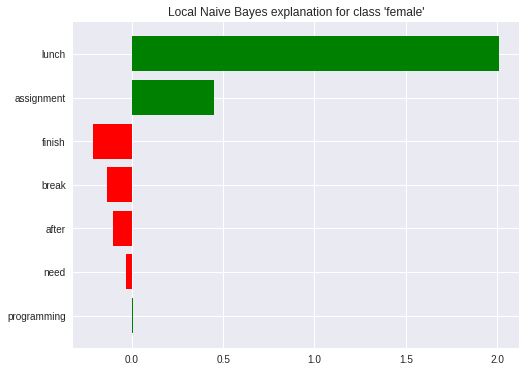

In [16]:
fig = plt.figure(figsize=(8,6))
plt.style.use('seaborn')
exp = sorted(expl, key=lambda x: abs(x[1]), reverse=True)
#fig = plt.figure(figsize=figsize)
vals = [x[1] for x in exp]
names = [x[0] for x in exp]
vals.reverse()
names.reverse()
colors = ['green' if x > 0 else 'red' for x in vals]
pos = np.arange(len(exp)) + .5
plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
if pred == 0:
    plt.title("Local Naive Bayes explanation for class 'male'")
else:
    plt.title("Local Naive Bayes explanation for class 'female'")
plt.show()

## Function to plot the explanations

In [17]:
def plot_explanations(sample_id, n_features=15, figsize=(18,7), verbose=True, **kwargs):
    fig = plt.figure(figsize=figsize)
    plt.style.use('seaborn')
    
    if verbose:
        print(full_overlap_df.post[sample_id], "\n\nTrue label =", full_overlap_df.label[sample_id], "(0: male, 1: female)")
    
    # BERT
    exp = sorted(full_overlap_df.ig[sample_id], key=lambda x: abs(x[1]), reverse=True)[:n_features]
    #fig = plt.figure(figsize=figsize)
    vals = [x[1] for x in exp]
    names = [x[0] for x in exp]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp)) + .5
    plt.subplot(1, 2, 1)
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    if full_overlap_df.pred[sample_id] == 0:
        plt.title("Local BERT explanation for class 'male'")
    else:
        plt.title("Local BERT explanation for class 'female'")
    
    # Naive Bayes
    exp = sorted(full_overlap_df.nb_exp[sample_id], key=lambda x: abs(x[1]), reverse=True)[:n_features]
    #fig = plt.figure(figsize=figsize)
    if full_overlap_df.pred[sample_id] == full_overlap_df.nb_pred[sample_id]:
        vals = [x[1] for x in exp]
    else:
        vals = [-x[1] for x in exp]
    names = [x[0] for x in exp]
    #vmax = max(vals)
    #if vmax > 1.0:
    #    vals = [x[1]/(vmax+0.1) for x in exp]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp)) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    if full_overlap_df.pred[sample_id] == 0:
        plt.title("Local Naive Bayes explanation for class 'male'")
    else:
        plt.title("Local Naive Bayes explanation for class 'female'")
    plt.show()

perfect epitome of demagogue ..jus too senitive..pat on her back n she yells as though we hit her wit iron for ..too moody n short tempered lik moi....n can pul her leg to any xtent n entertain urselves ...al teachers fond of her ..(hw come aish)...helpful... strng in concepts she noes..jus has too many fans....perfect lab partner..while away tym either trying most complicated concepts(which we doubt if we act thought ourselves) or jus yawning n blabbing utter crap n talking like imbecile ppl ..awesom teacher she can bcome..al d seminars taken til date impressive n increased her fan club....btw hw can i forget abt d jarring lunch box..sema attractive da...n neva opens..nice ting for u 2 play wit..n ya wat an ice cream lover..major hand in comleting entire family pack ise cream..n requires no company.. 

True label = 1 (0: male, 1: female)


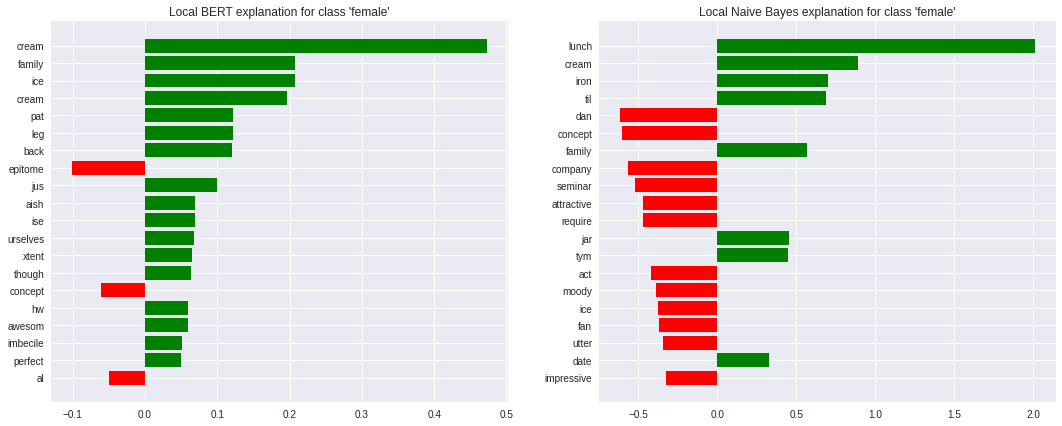

In [18]:
plot_explanations(0, n_features=20)

## Process explanations such that they are comparable

### For IG explanations: join the words that were split by BERT's tokenizer (e.g. 'stack' '##ing' -> 'stacking')

In [19]:
full_overlap_df.ig[353] #here for instance the word 'discernible' was split into 'disc', '##ern', '##ible'

[('small', 0.05919924606883617),
 ('island', 0.056827597516987634),
 ('discernible', 0.11476892609759848),
 ('distance', 0.10019387912556436),
 ('destination', 0.026208065001468696),
 ('day', 0.046524507878684285),
 ('local', 0.15390649100617357),
 ('diver', 0.26556557095118427),
 ('apo', -0.048752542914083236),
 ('island', 0.04908856437756199),
 ('know', 0.058512828377008747),
 ('rich', 0.030385023479251597),
 ('underwater', 0.2851882503324004),
 ('life', -0.2241755798801522)]

In [77]:
def contains_substring(tuple_list, substring):
    for t in tuple_list:
        if t[0].startswith(substring):
            return True
    return False

In [78]:
for idx in range(len(full_overlap_df.ig)):
    while contains_substring(full_overlap_df.ig[idx], '##'):
        for i,exp in enumerate(full_overlap_df.ig[idx]):
            # exp[0]: feature name, exp[1]: feature importance
            if exp[0].startswith('##'):
                new_feat = full_overlap_df.ig[idx][i-1][0] + exp[0][2:]
                if abs(full_overlap_df.ig[idx][i-1][1]) > abs(exp[1]):
                    new_attrib = full_overlap_df.ig[idx][i-1][1]
                else:
                    new_attrib = exp[1]
                full_overlap_df.at[idx,'ig'][i-1] = (new_feat, new_attrib)
                full_overlap_df.at[idx,'ig'].pop(i)

#### Also: remove punctuation and stopwords, to make BERT and Naive bayes more comparable

In [79]:
stop_words = stopwords.words('english')
stop_words.append('[CLS]')
stop_words.append('[SEP]')

for idx in range(len(full_overlap_df.ig)):
    delete = []
    for i,exp in enumerate(full_overlap_df.ig[idx]):
        if exp[0] in stop_words:
            delete.append(i)
        if exp[0] in string.punctuation:
            delete.append(i)
        if len(exp[0]) < 2 and exp[0] != 'i':
            delete.append(i)
    delete = sorted(set(delete), reverse=True)
    for d in delete:
        full_overlap_df.at[idx,'ig'].pop(d)

#### Lastly: Lemmatize all features

In [80]:
tag_map = defaultdict(lambda : wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV
lemmatizer = WordNetLemmatizer()

for idx in range(len(full_overlap_df.ig)):
    for i,exp in enumerate(full_overlap_df.ig[idx]):
        # exp[0]: feature name, exp[1]: feature importance
        token,tag = pos_tag([exp[0]])[0]
        lemma = lemmatizer.lemmatize(token, tag_map[tag[0]])
        if len(lemma) < 2:
            lemma = exp[0]
        full_overlap_df.at[idx,'ig'][i] = (lemma, exp[1])

In [81]:
full_overlap_df.ig[353]

[('small', 0.05919924606883617),
 ('island', 0.056827597516987634),
 ('discernible', 0.11476892609759848),
 ('distance', 0.10019387912556436),
 ('destination', 0.026208065001468696),
 ('day', 0.046524507878684285),
 ('local', 0.15390649100617357),
 ('diver', 0.26556557095118427),
 ('apo', -0.048752542914083236),
 ('island', 0.04908856437756199),
 ('know', 0.058512828377008747),
 ('rich', 0.030385023479251597),
 ('underwater', 0.2851882503324004),
 ('life', -0.2241755798801522)]

A small island was discernible from the distance, our destination for that day. For locals and divers, that was Apo Island, known for its rich underwater life.  

True label = 1 (0: male, 1: female)


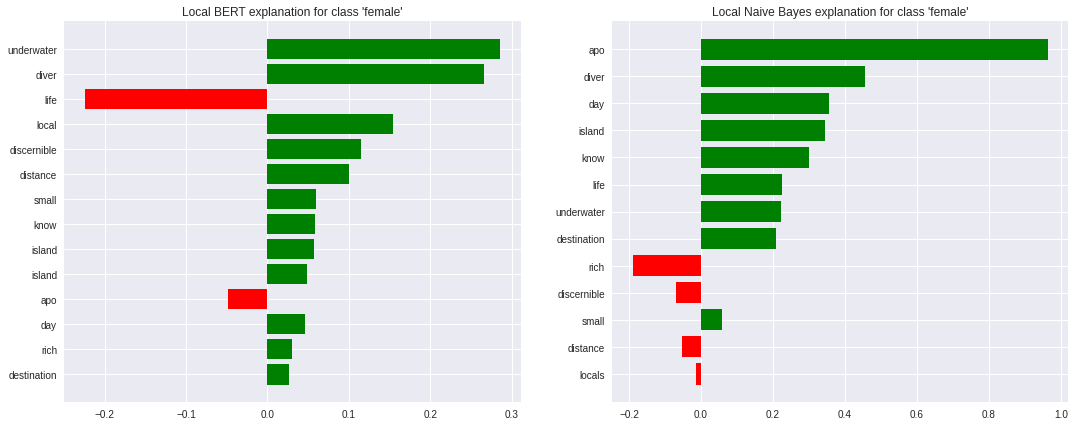

In [20]:
plot_explanations(353)

## For each explanation: Extract top *X* features and calculate overlap

In [27]:
# Calculating overlap:
# only features that are important for the same class: I.e. do not count features if BERT considers it to be male whereas Naive Bayes as female
# also count BERT features that occur in Bayes' bigrams and trigrams (e.g. "skin" and "skin tone" are an overlap)

def overlap(sample_id, n_feat=25):
    sample = full_overlap_df.iloc[sample_id]
    top_bert = sorted(sample.ig, key=lambda x: abs(x[1]), reverse=True)[:n_feat]
    top_bayes = sorted(sample.nb_exp, key=lambda x: abs(x[1]), reverse=True)[:n_feat]

    bert_feat = [t[0] for t in top_bert]
    bert_attrib = [t[1] for t in top_bert]
    bayes_feat = [t[0] for t in top_bayes]
    if sample.pred == sample.nb_pred:
        bayes_attrib = [t[1] for t in top_bayes]
    else:
        bayes_attrib = [-t[1] for t in top_bayes]

    overlap = []
    opposing = []
    for i,feat in enumerate(bert_feat): 
        if feat in bayes_feat:
            bayes_idx = bayes_feat.index(feat)
            if np.sign(bert_attrib[i]) == np.sign(bayes_attrib[bayes_idx]):
                overlap.append(feat)
            else:
                opposing.append(feat)

    overlap_ratio = len(overlap)/len(bert_feat)  #unsure if set(overlap)?
    return (overlap_ratio, overlap, opposing) #unsure if set(overlap) and set(opposing) should be used?

All facials follow the same basic structure and order. They will begin with makeup removal and cleansing. The cleansing is normally repeated twice to ensure it is thorough. Then comes some method of exfoliation to remove dead skin cells and smooth the surface of the skin. A massage is then performed that can include all or some of the scalp, face, neck, shoulders, back and even the hands or feet. Next a mask is applied, chosen according to the client’s specific skin type. Once the mask has been removed the skin is toned and the final eye, neck and face creams are applied. 

True label = 1 (0: male, 1: female)


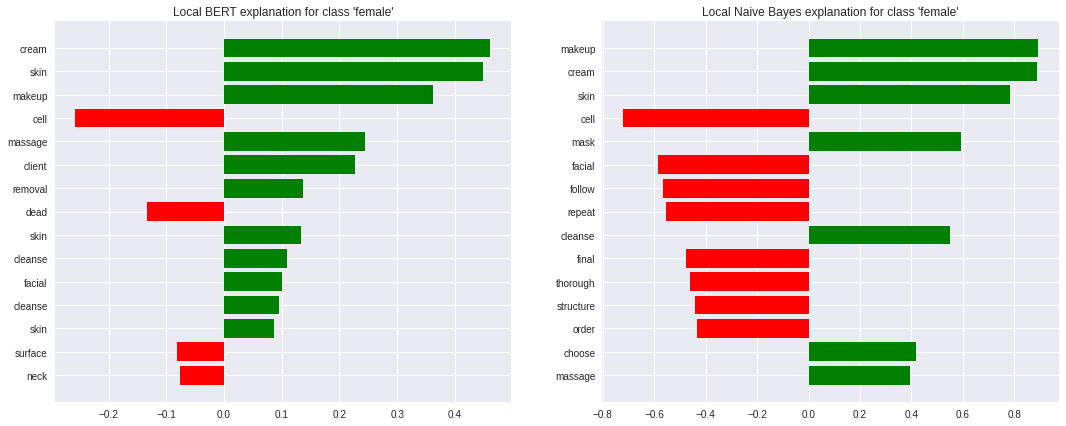

In [28]:
plot_explanations(16)

In [29]:
test = overlap(sample_id=16)
print("Overlap =" , test[0]*100, "% :", test[1])
print("Opposing words :" , test[2])

Overlap = 52.0 % : ['cream', 'skin', 'makeup', 'cell', 'massage', 'dead', 'skin', 'cleanse', 'cleanse', 'skin', 'structure', 'order', 'skin']
Opposing words : ['facial', 'surface', 'smooth', 'mask', 'perform']


In [30]:
# calculate overlap for all data samples
overlap_ratio = []
overlap_words = []
opposing_words = []
N_FEAT = 20

for idx,sample in full_overlap_df.iterrows():
    res = overlap(idx, N_FEAT)
    overlap_ratio.append(res[0]) 
    overlap_words.append(res[1])
    opposing_words.extend(res[2])

In [31]:
full_overlap_df['overlap'] = overlap_ratio
full_overlap_df['overlap_words'] = overlap_words
#full_overlap_df.to_csv('../data/full_overlap_df.csv', index=False)

In [32]:
print("Mean:", np.mean(full_overlap_df.overlap)*100, "%")
print("Median:", np.median(full_overlap_df.overlap)*100, "%")
print("Max:", max(full_overlap_df.overlap), "%")

Mean: 27.598295875294326 %
Median: 25.0 %
Max: 0.8333333333333334 %


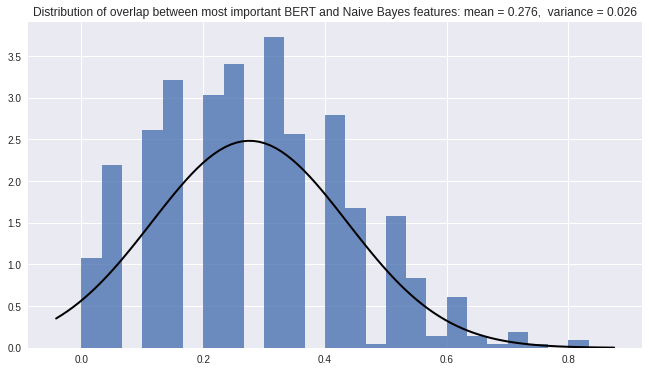

In [33]:
# Plot the histogram.
mu, std = norm.fit(full_overlap_df.overlap)
plt.figure(figsize=(11,6))
plt.style.use('seaborn')
plt.hist(full_overlap_df.overlap, bins=25, density=True, alpha=0.8)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Distribution of overlap between most important BERT and Naive Bayes features: mean = %.3f,  variance = %.3f" % (mu, std**2)
plt.title(title)
plt.show()

### Wordcloud from female and male overlap

In [34]:
female = []
for l in full_overlap_df.overlap_words[full_overlap_df['pred'] == 1]:
    female.extend(l)

male = []
for l in full_overlap_df.overlap_words[full_overlap_df['pred'] == 0]:
    male.extend(l)

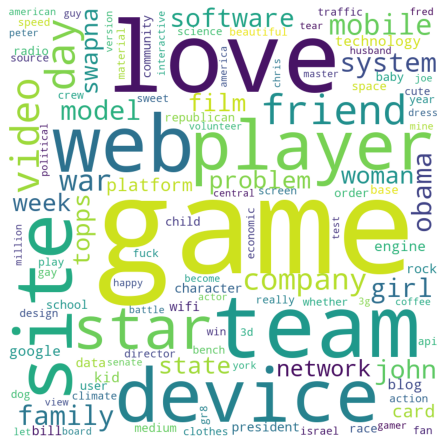

In [35]:
comment_words = " ".join(male)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', collocations=False,
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

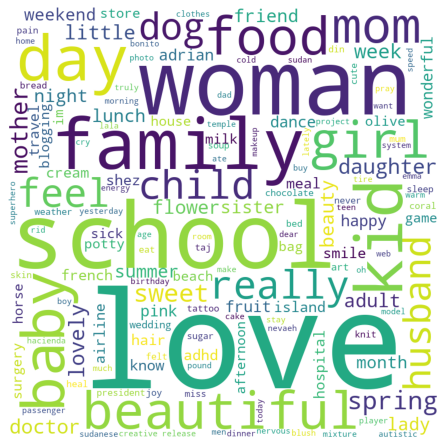

In [36]:
comment_words = " ".join(female)
wordcloud = WordCloud(width = 800, height = 800,
                background_color='white', collocations=False,
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

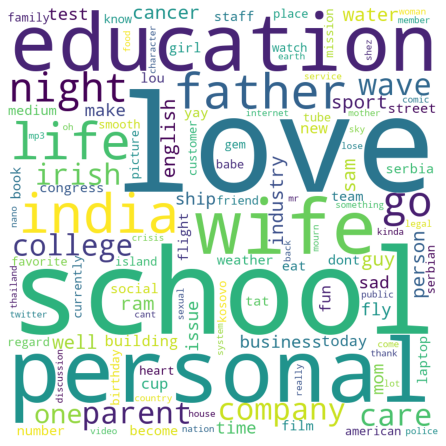

In [37]:
comment_words = " ".join(opposing_words)
wordcloud = WordCloud(width = 800, height = 800,
                background_color='white', collocations=False,
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### specifically male/female overlap

In [41]:
male_overlap = []
female_overlap = []
N_FEAT = 15

for idx,sample in full_overlap_df.iterrows():
    top_bert = sorted(sample.ig, key=lambda x: x[1], reverse=True)[:N_FEAT]
    bert_feat = [t[0] for t in top_bert]
    bert_attrib = [t[1] for t in top_bert]
    
    if sample.pred == sample.nb_pred:
        top_bayes = sorted(sample.nb_exp, key=lambda x: x[1], reverse=True)[:N_FEAT]
        bayes_feat = [t[0].split() for t in top_bayes]
        bayes_attrib = [t[1] for t in top_bayes]
    else:
        top_bayes = sorted(sample.nb_exp, key=lambda x: x[1], reverse=False)[:N_FEAT]
        bayes_feat = [t[0].split() for t in top_bayes]
        bayes_attrib = [-t[1] for t in top_bayes]        
    
    for i,feat in enumerate(bert_feat):
        if any(feat in sublist for sublist in bayes_feat):
            bayes_idx = find_in_nested_list(feat, bayes_feat)
            if np.sign(bert_attrib[i]) == np.sign(bayes_attrib[bayes_idx]) == 1:
                if sample.pred == 0:
                    male_overlap.append(feat)
                else:
                    female_overlap.append(feat)
            if np.sign(bert_attrib[i]) == np.sign(bayes_attrib[bayes_idx]) == -1:
                if sample.pred == 0:
                    female_overlap.append(feat)
                else:
                    male_overlap.append(feat)

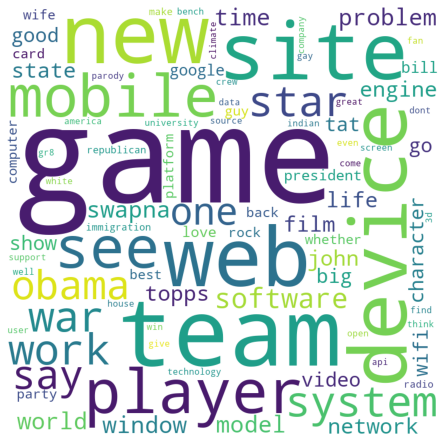

In [42]:
comment_words = " ".join(male_overlap)
wordcloud = WordCloud(width = 800, height = 800,
                background_color='white', collocations=False,
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

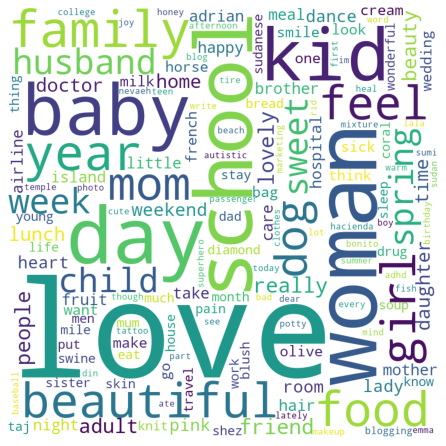

In [43]:
comment_words = " ".join(female_overlap)
wordcloud = WordCloud(width = 800, height = 800,
                background_color='white', collocations=False,
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Explanation plots

Living with roommates is a very unique experience. However it is up to you how you go about it. Your house can be like a hotel with different people staying in it, minding their own business, cooking for themselves or it can be a wonderful, funny place. A real home away from home. That happens when you make an effort to connect with your roomies and make it a point to do some things together. My seniors have always managed to cheer me up every time I felt down. Life here for me has been filled with moments of homesickness. Disappointments. Depression. Hunger. Financial crunch... And yet I laugh at most times and bury myself in work at the other times. A bunch of seniors who have helped me out since the day i landed are...  Life is fast right now. I wake up each day and by the time I crash down again, all is a blur. I still can't digest that it has been two whole months since I boarded that flight from Muscat and arrived at Chicago- not knowing a soul here! Life gets tough once in a whi

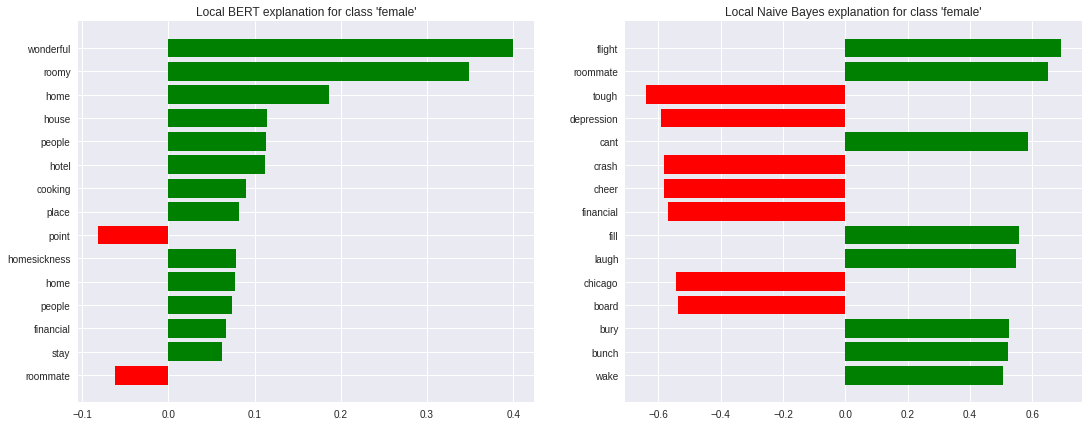

,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
399,Living with roommates is a very unique experie...,1,"[(living, 0.02052028718298198), (roommate, -0....",Living with roommates is a very unique experie...,1,0.071533,212,"['live', 'roommate', 'unique', 'experience', '...","[(yet, 0.1267685851515381, -8.560242162692788,...",1,0.05,[wonderful]


In [38]:
i = 399
plot_explanations(i)
full_overlap_df[full_overlap_df.index == i]

30 Rock is a very...unique...show.  It's very easy to see why the Emmys flock to it like tweens to a Taylor Lautner poster; there's simply nothing else like it on TV.  A show like The Office usually goes out for more obvious discomfort-related gags, while 30 Rock engages a much more rapid-fire hit and miss of total absurdity.  It's been a few weeks since we've seen lachrymose Liz Lemon, even after the Olympics, and I can honestly say I missed the witty offbeat charm 30 Rock does so well.

 

True label = 0 (0: male, 1: female)


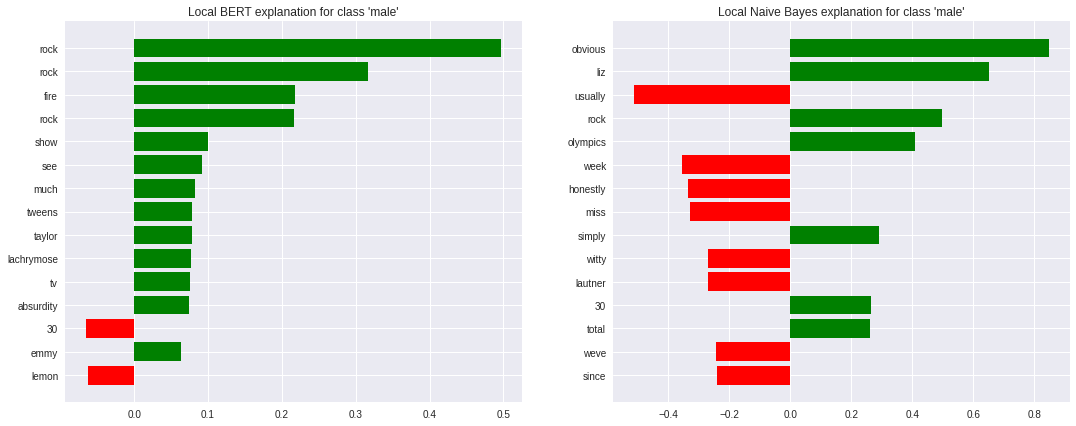

,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
17,30 Rock is a very...unique...show. It's very ...,0,"[(30, -0.03407788072869303), (rock, 0.49668696...",30 Rock is a very...unique...show. It's very ...,0,0.072565,89,"['30', 'rock', 'veryuniqueshow', 'easy', 'see'...","[(witty, -0.2708637493889192, -10.831925752608...",0,0.15,"[rock, rock, rock]"


In [39]:
i = 17
plot_explanations(i)
full_overlap_df[full_overlap_df.index == i]

I picked her up on Saturday, after a night of lots of partying and little sleeping. Yes, I'm gangster. We didn't get home until 5 in th morning on Sunday. We had lots of fun. We kayaked, shopped, tried on tons of clothes in a co-ed dressing room (I got caught by a male worker in my bra, then later, dancing retardedly - sweet! as in, embarrassing), went on rescue missions with the boys (rescued a boat load of unshaven, smelly, barefoot.. hippies! The stinkiest rescue mission of all time, thanks Bob!), got pedicures, paddled at midnight to see phosphorescence, oogled hot guys, barbecued at Jays, crashed a dinner party at Tugboat Annies...  and I even got away with some stuff that I'd never have gotten away with if Joshlynn wasn't there. Like taking pictures of ourselves in the round mirror in the middle of the marina store. 

True label = 1 (0: male, 1: female)


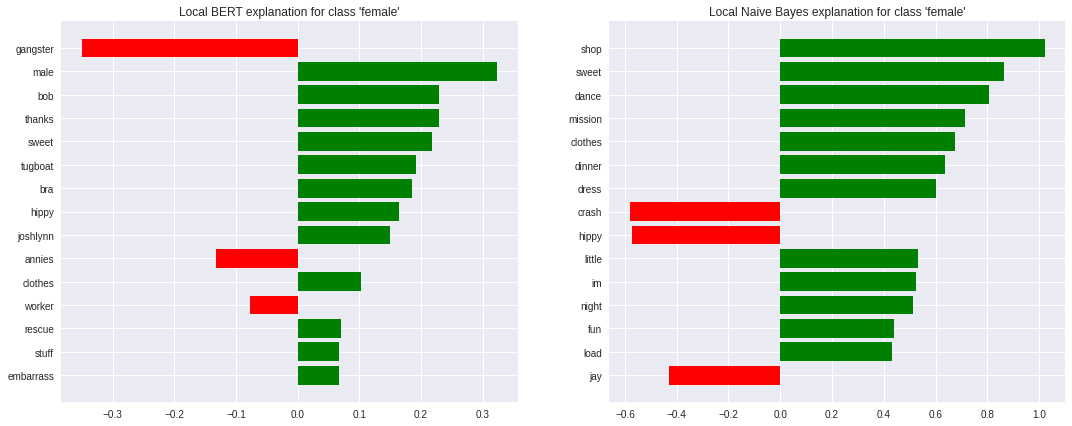

,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
322,"I picked her up on Saturday, after a night of ...",1,"[(picked, -0.020465867534254615), (saturday, -...","I picked her up on Saturday, after a night of ...",1,0.003938,148,"['pick', 'saturday', 'night', 'lot', 'party', ...","[(yes, -0.028561264146334864, -8.5805172496610...",1,0.1,"[sweet, clothes]"


In [40]:
i = 322
plot_explanations(i)
full_overlap_df[full_overlap_df.index == i]

A small island was discernible from the distance, our destination for that day. For locals and divers, that was Apo Island, known for its rich underwater life.  

True label = 1 (0: male, 1: female)


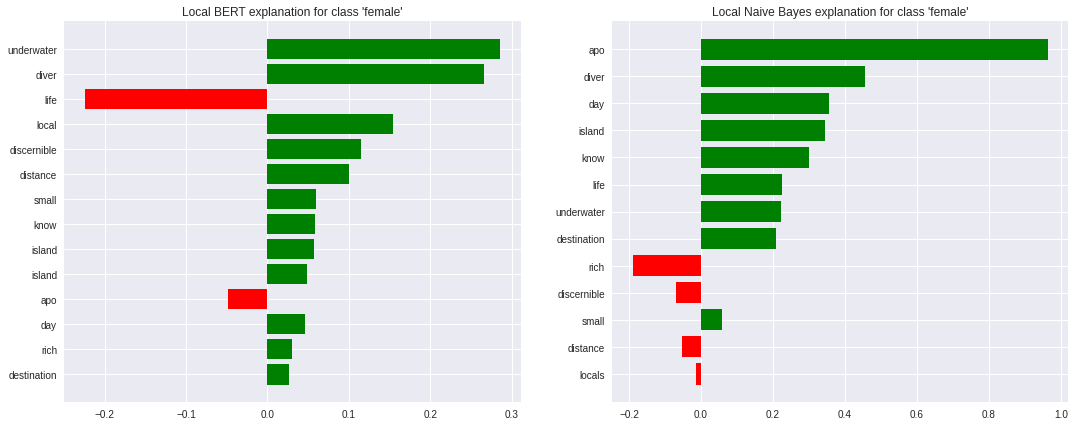

,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
353,A small island was discernible from the distan...,1,"[(small, 0.05919924606883617), (island, 0.0568...",A small island was discernible from the distan...,1,0.097079,27,"['small', 'island', 'discernible', 'distance',...","[(underwater, 0.22085216609738723, -10.8876256...",1,0.571429,"[underwater, diver, small, know, island, islan..."


In [41]:
i = 353
plot_explanations(i)
full_overlap_df[full_overlap_df.index == i]

I am not the typical RPG gamer. I have never been a fan of the games where you pick your actions from a menu. This is a real-time RPG. It is wide open from the begining, although one might want to watch where they venture. High-level nasties, and locked doors may block your way. If you are a mage, dispatching the baddies will come easier. If you are a theif, you can take care of those pesky locks with ease. But, your class is not limited. 

True label = 0 (0: male, 1: female)


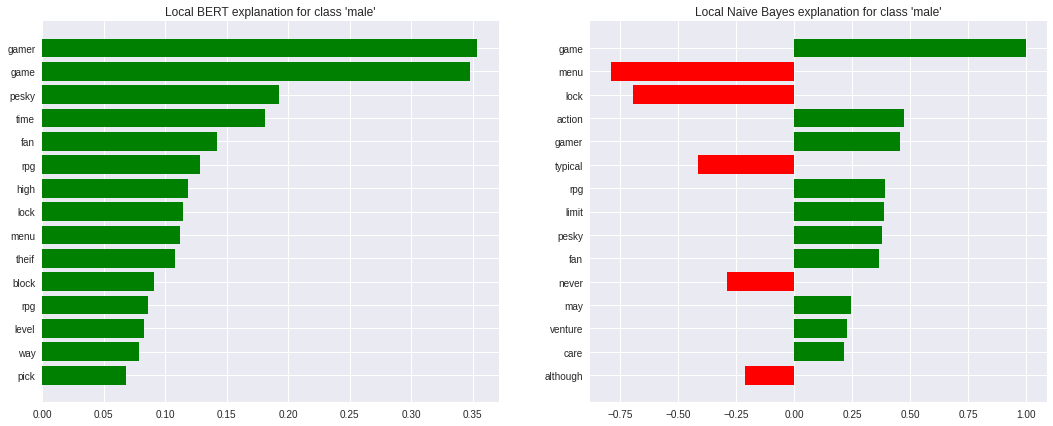

,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
138,I am not the typical RPG gamer. I have never b...,0,"[(typical, 0.05471321374179136), (rpg, 0.08629...",I am not the typical RPG gamer. I have never b...,0,-0.002828,86,"['typical', 'rpg', 'gamer', 'never', 'fan', 'g...","[(wide, -0.029201356825394598, -9.784457021662...",0,0.35,"[gamer, game, pesky, fan, rpg, rpg, action]"


In [42]:
i = 138
plot_explanations(i)
full_overlap_df[full_overlap_df.index == i]

No other country, with a history of successful education, applies economic principles of competition and incentives to the teaching profession. It’s too narrow-focused. There are so many other variables to consider. Community, family, individual differences. Schools are not factories. No other nation, with a successful school system, abandons courses in cultural subjects, like music and foreign languages, to focus only on basic skills and testing. 

True label = 0 (0: male, 1: female)


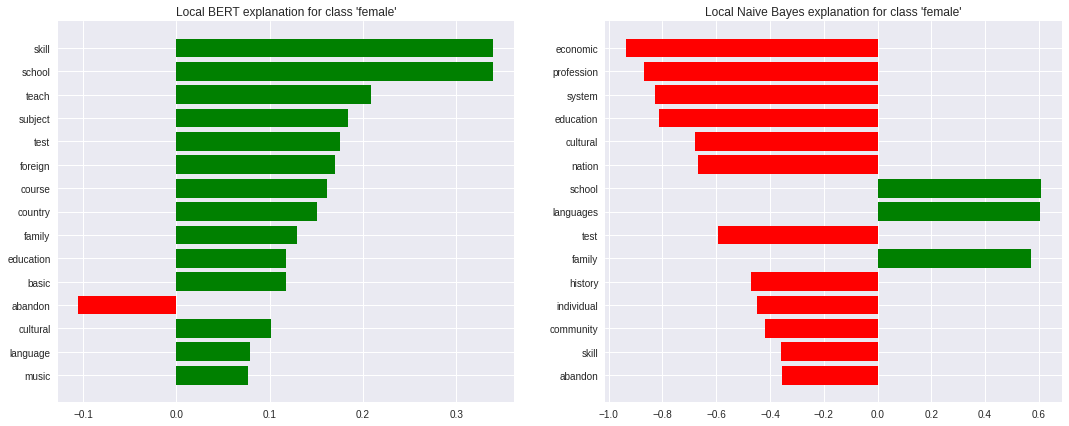

In [43]:
plot_explanations(371)

In a medium saucepan, melt the remaining 2 tablespoons butter. Stir in the turkey and flour. Add the milk, and heat through. Stir the turkey mixture into the vegetable mixture, and cook until thickened. Cool slightly, then pour mixture into the unbaked pie shell. Roll out the top crust, and place on top of filling. Flute edges, and make 4 slits in the top crust to let out steam.  

True label = 1 (0: male, 1: female)


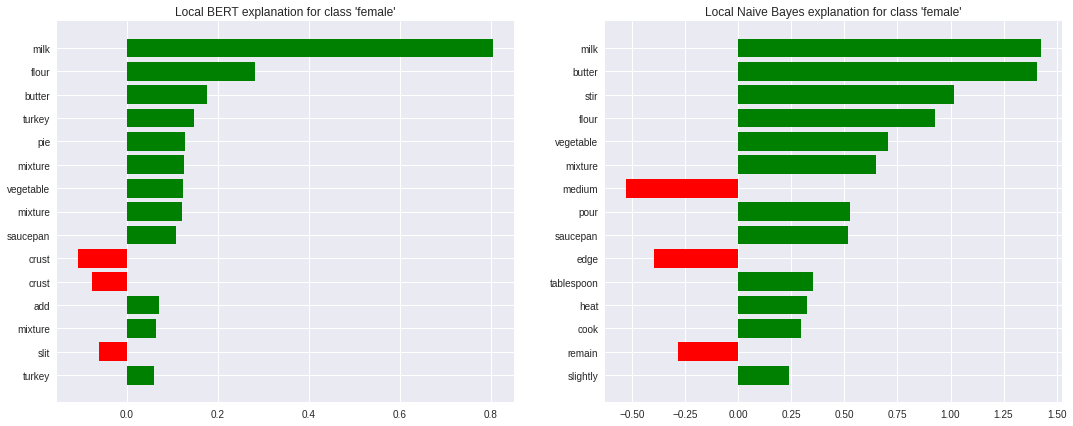

In [44]:
plot_explanations(194)

In 1970 I got out of the Navy..... and at that time met my soon to be wife Deborah she was a school teacher. One year later we were married. For the next 2 years Debbie was teaching high school so that I could go to culinary arts school to become a chef.

 

True label = 0 (0: male, 1: female)


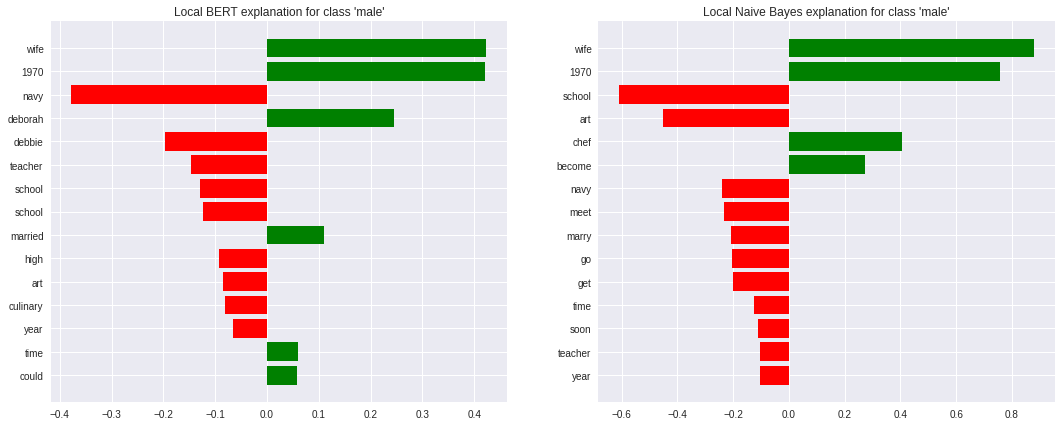

In [45]:
plot_explanations(159)

I'm not saying that America is this terrible disgusting country. Well I'm not completely saying that. What I am commenting on is the the patriotism of American's that seem to always offend other countries when speaking of how great America is. You don't see African's saying look at those Indonesians starving bastards! No because it's almost like the pot calling the kettle black.
 

True label = 0 (0: male, 1: female)


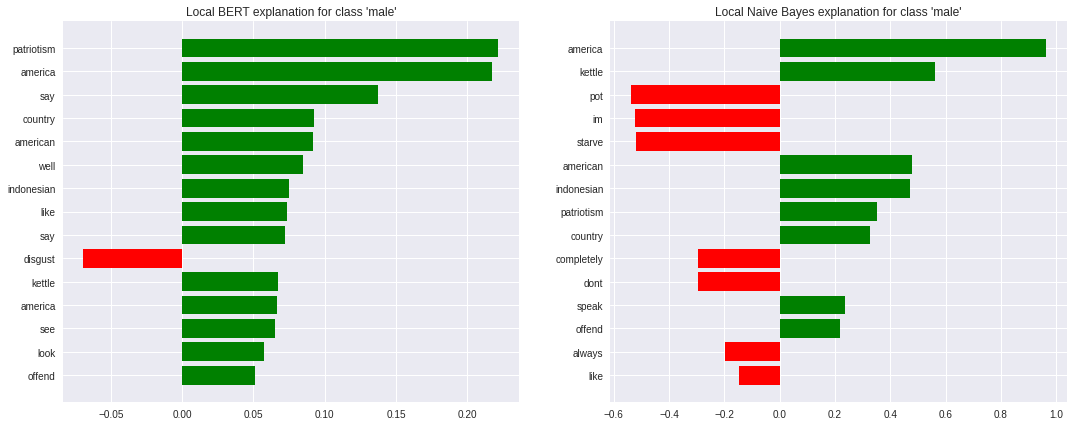

In [46]:
plot_explanations(145)

This was high season and spoilt and busy? We were soaked and there was no place to stay, yet after the noisy crowds of the other islands, this was a chance to exhale.  

True label = 0 (0: male, 1: female)


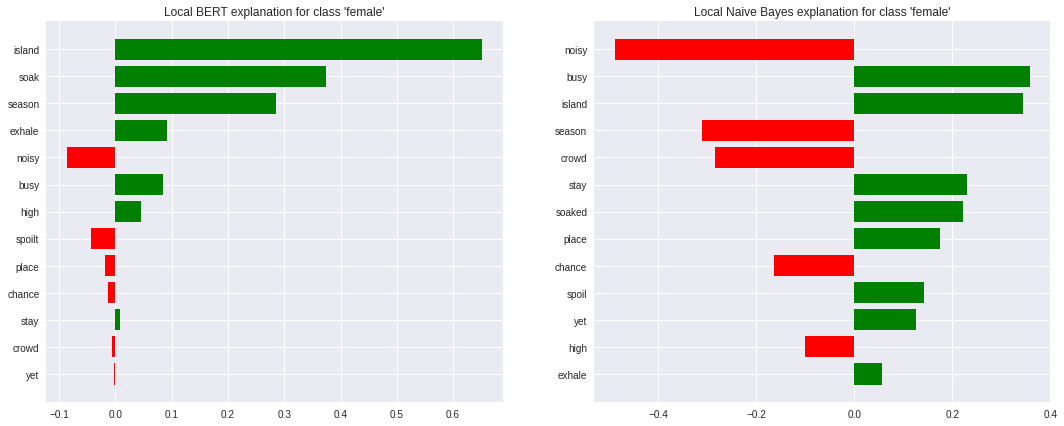

In [47]:
plot_explanations(586)

I think any universal health care plan would have to come with a income based scheme or means testing. If you can afford to pay for health care you should pay, however you would be able to recieve a percentage back through a medicare rebate scheme.  

True label = 0 (0: male, 1: female)


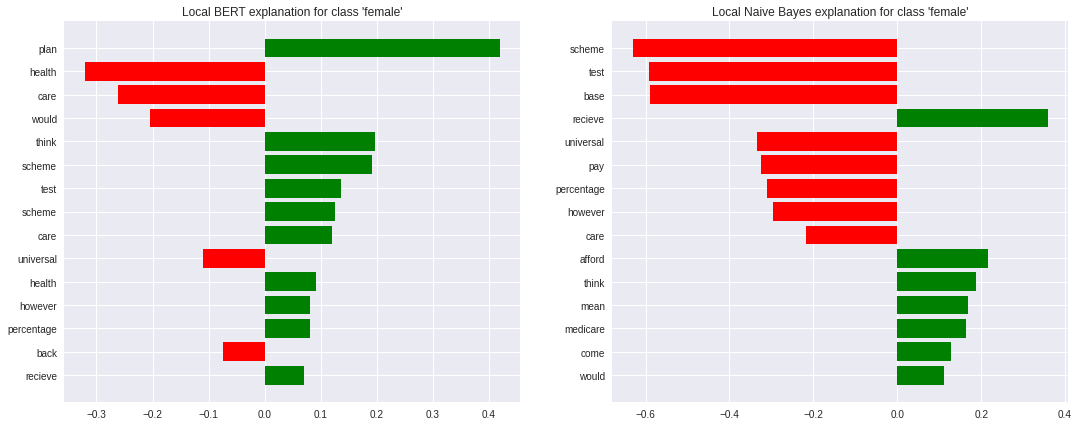

In [48]:
plot_explanations(563)

How can I change the volume licensing product key on a Windows XP SP1-Based Computer?

Because of changes in Windows XP Service Pack 1 (SP1), Windows XP-based computers that use a leaked product key that is known to be available to the general public may not be able to install SP1 or automatically obtain updates from the Windows Update Web site. For an easy and quick method of obtaining your own CD Key please read Quickly Retrieve Windows CD Key. 

True label = 1 (0: male, 1: female)


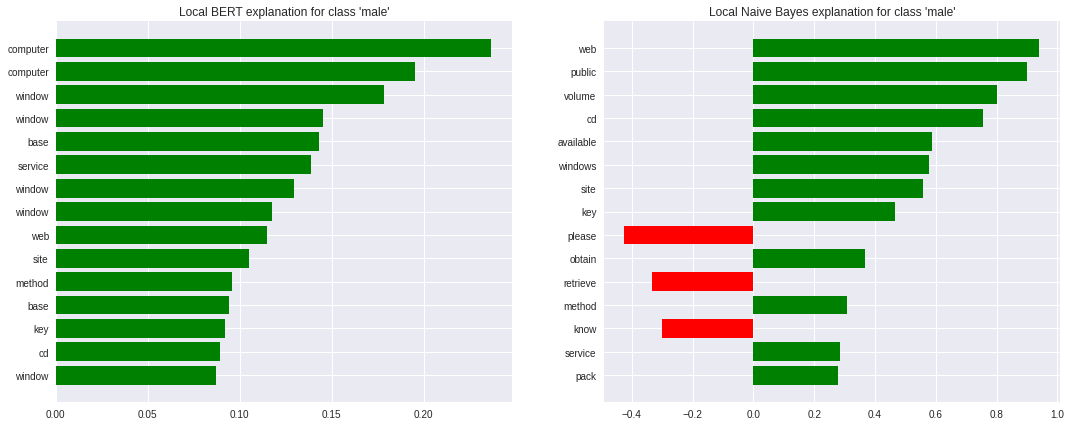

In [49]:
plot_explanations(163)

Many cultures have used honey for medicinal purposes. Some use it as a healing paste for dealing with the pain of arthritis. Some oriental cultures use honey in their tea to help reduce the amount of bad cholesterol. Some believe in its ability to soothe sore throats and treat common head colds, and others that it can help with upset stomachs, indigestion, and even gastroenteritis and diarrhoea. There is also evidence that honey has cleansing properties to keep the human body healthy and in tip-top working order all year round. 

True label = 1 (0: male, 1: female)


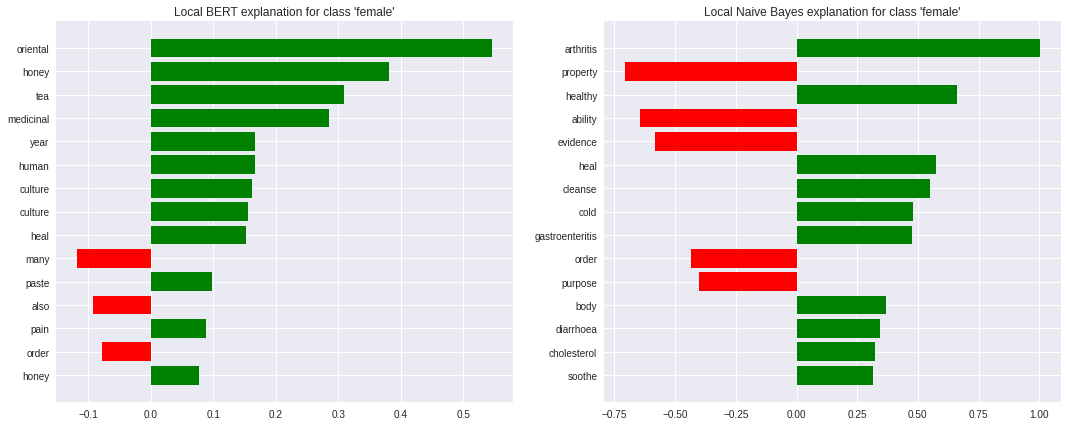

In [50]:
plot_explanations(137)

evlon challenges its customers to “Get Cheeky” with their new Pinch Me Sheer Gel Blush. Being the makeup junkie that I am, I rose to the challenge and decided to give this new product a try. I did hesitate for a brief minute since I’d never heard anything positive about blush gels, but ultimately I decided to jump on in. I’m glad that I did! 

True label = 1 (0: male, 1: female)


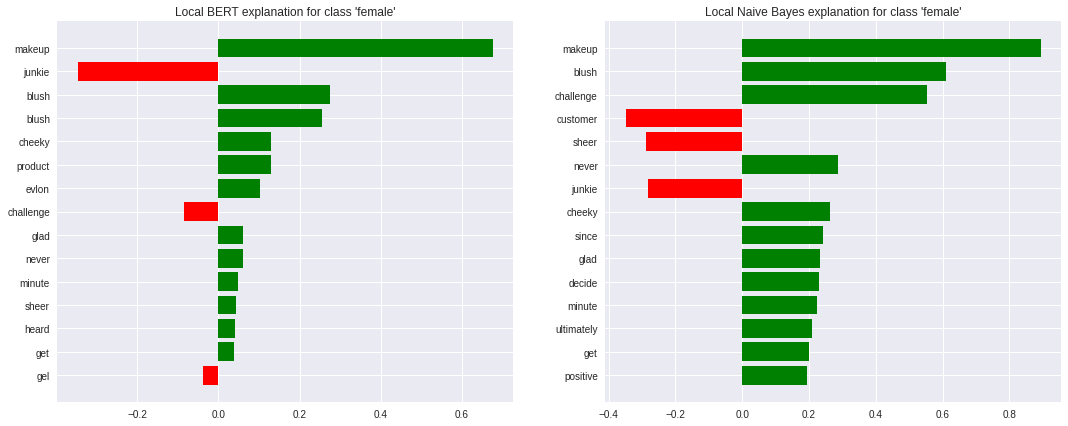

In [51]:
plot_explanations(283)

You know life is life you can’t really chose where it takes you, god has a reason for everything that is the way I look at it. Sure you going to lose those you think you love and those you do, but if it wasn’t meant to be, there is nothing you can do but love, live and go on about your life. Sometime you get to the point when you have to just stop and think about all the positive things that have happened to you and stop thinking about the things in your life that you have fucked up, or things that have happened to you. My life has taken many many turn's some for the good some for the bad, but I am who I am from my past. I have many people that have been there for me throw everything and some that are just there to support me when I need someone to talk to, I am very thankful for those people and you know who you are. But I have to thank my dad for most of it, we have had are times like may may kids but he has never giving up on me even sometimes when he wanted to just drop kick me in 

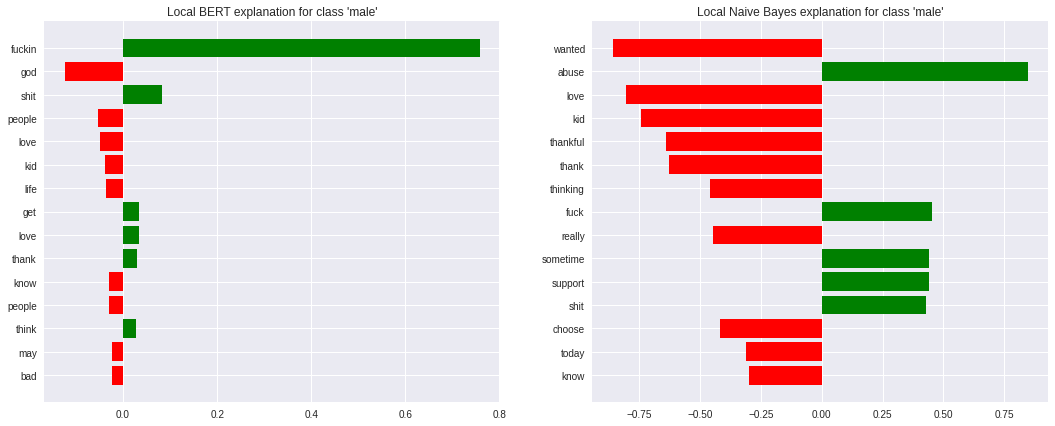

In [52]:
plot_explanations(348)

Did not win on Friday. In fact, only got one digit right. And another work week starts and it still counts what I do at work. As you can see I didn't "open the box" by playing those numbers. I guess I'm lucky! Let's see if 2010 brings some surprises. not much news. did not get struck by lightning (yay), did not win the lottery (yay, not). anyway...we'll try again  

True label = 0 (0: male, 1: female)


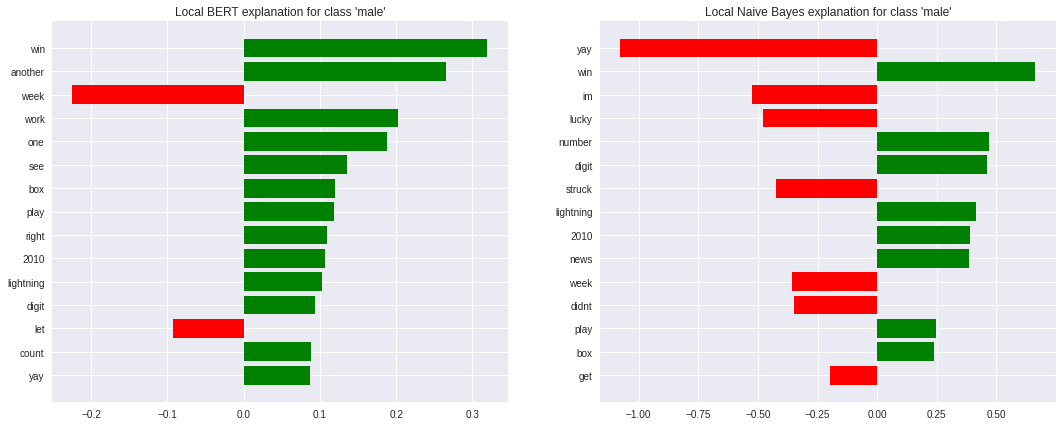

In [53]:
plot_explanations(9)

I had a wonderful encounter with God yesterday.

In an ordinary moment, He caught me by surprise. He met me where I was. He heard my cry. He spoke truth into my heart. 

We are going through a deep, dark valley, facing a personal battle that has turned everything upside down and inside out. I am praying, praying, praying - for healing, for deliverance, for grace, for strength. It is the hardest season we've walked through in our twelve years together - and if you know us, you know that we've had our share of hard seasons. 

Yesterday, I needed to be with other believers. I was drained. I needed to share my burden and be lifted up in prayer. I needed encouragement and nourishment from God's word. So, I left my sick children at home with Ben and went to our wonderful House Church.

Our leader took us into the book of Daniel, and the story of Shadrach, Meshach, and Abednego. Inside of such a familiar tale, God brought new revelation that spoke so clearly to my need, I could hardly contain

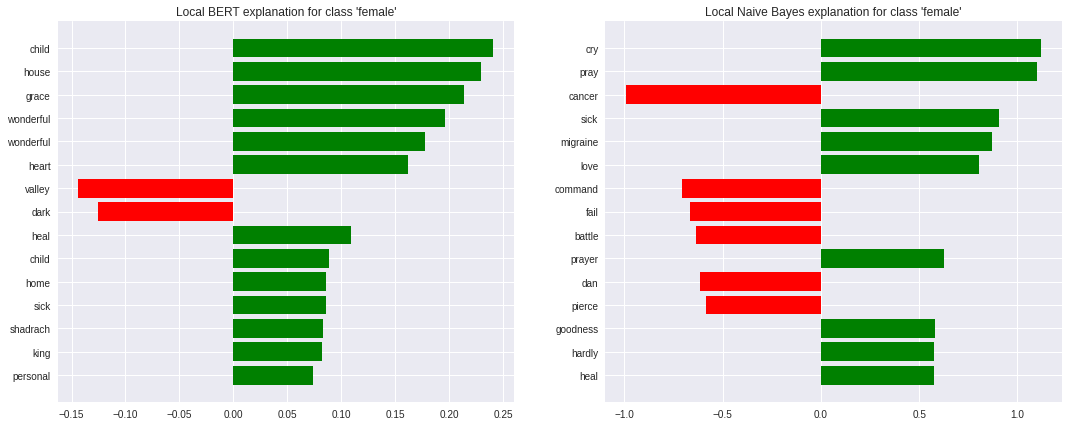

In [54]:
plot_explanations(7)

Index: 3
The weather in this part of the globe is once again changing. The slight chill in the air has ebbed away and Philippine summer seems to be entering earlier than expected. It’s not really a sudden shift because in our tropical country, weather conditions could be rainy, normal (dry and warm), and warmer.  Most of the time, the sun would be out.  

True label = 1 (0: male, 1: female)


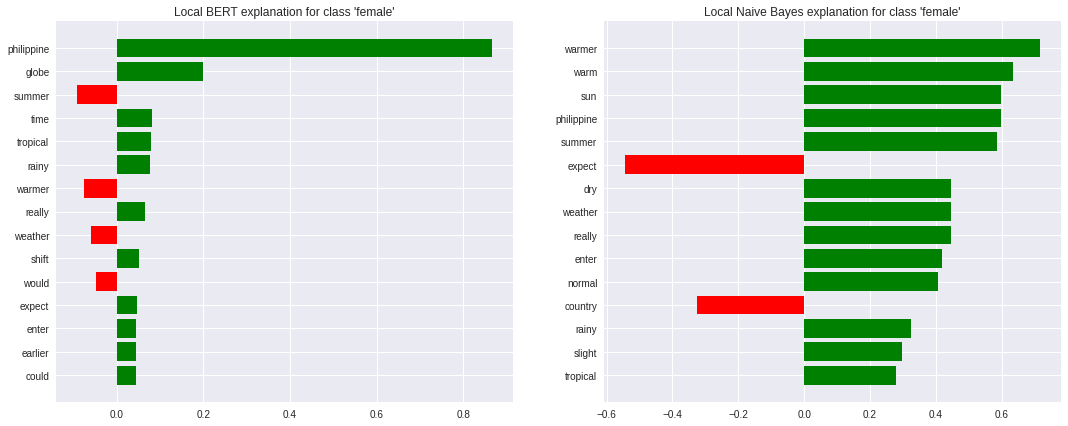

Index: 11
I love the great customer service by the flight attendants,pilots and ticketing agents.The fares are really reasonable.They need more food options to offer to the passengers.   

True label = 1 (0: male, 1: female)


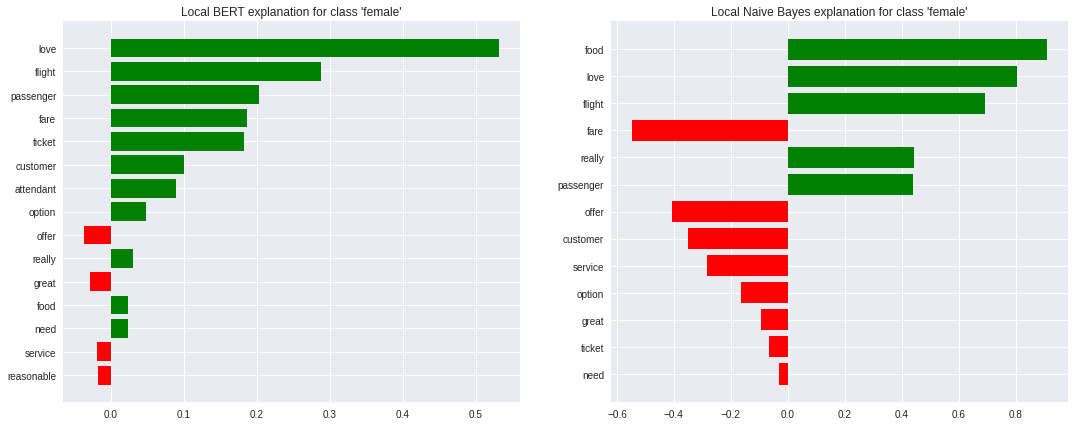

Index: 29
For the last couple, maybe three weeks I have become crazy watching movies during the weekends. I just turn on the television and start watching the movie that is currently playing, usually its one of the cute ones with Steve Martin, Sanjay Dutt, Paresh Rawal or Lindsay Lohen. 

True label = 0 (0: male, 1: female)


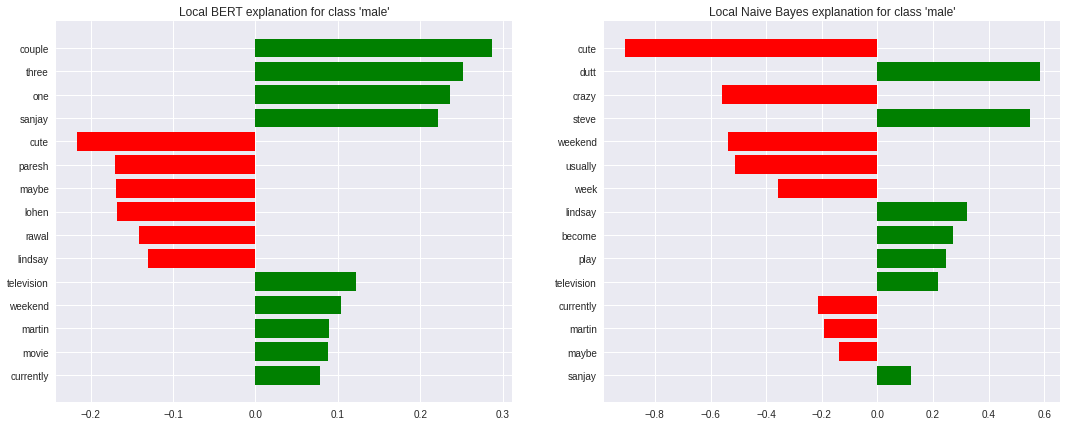

Index: 31
 My dear friend Carol, who walks with me, made an interesting comment as we were finishing our six mile jaunt. She said before she got into walking in the winter with me, she only thought of it as something she had to get through to reach Spring.   

True label = 1 (0: male, 1: female)


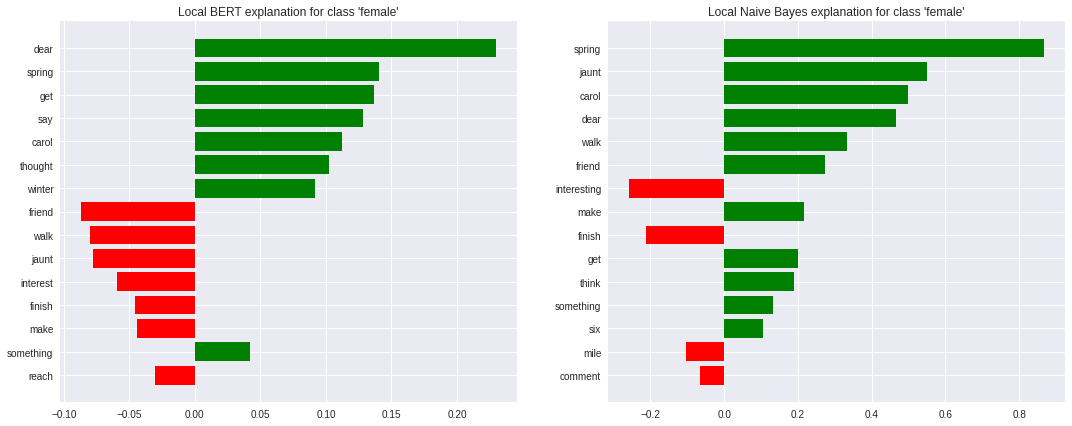

Index: 66
The Lounge (left) gives your iPhone 3GS or 3G a place to recline, whether on your desktop or on a dashboard, so you can easily view the screen. Its main use is with GPS applications, but it's also handy when you want to watch a video. It lists for $49.99.  

True label = 0 (0: male, 1: female)


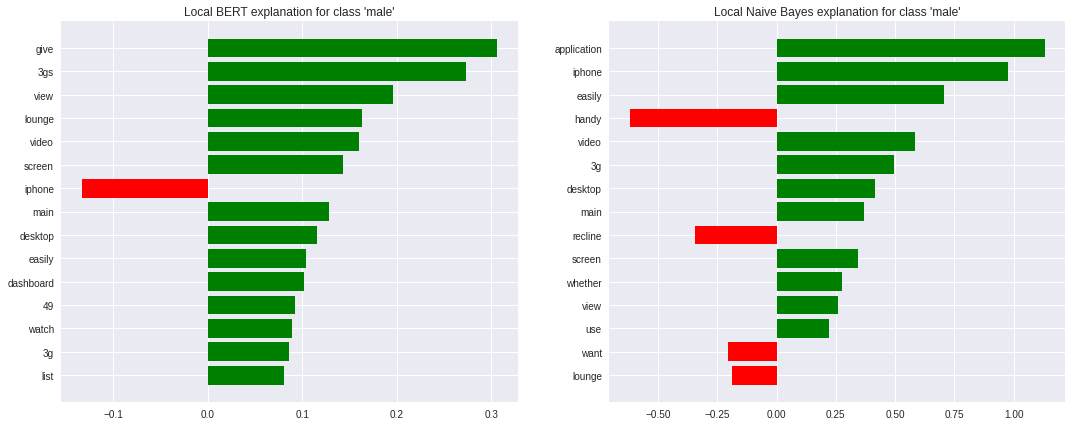

Index: 79
Also-start a secure transmission database for perscriptions-that way people will not be able to forge signatures or visit tons or doctors to abuse perscription drugs. This would also cut down on potentially harmful drug interactions. Or dosage mistakes due to sloppy handwriting. This will also cut down on the malpractice claims.  

True label = 1 (0: male, 1: female)


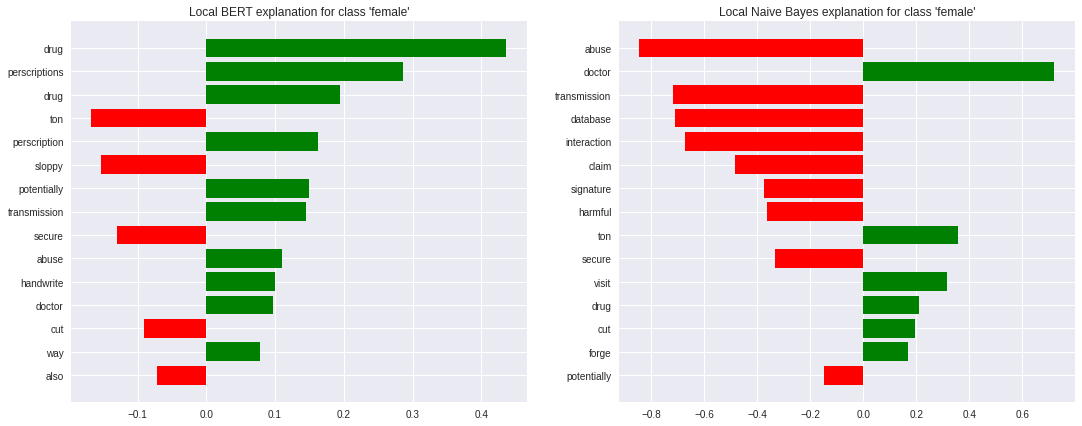

Index: 91
Several foreigners were also staying at the island to dive at nearby reefs and diving spots. But for us, we were contented with just snorkeling at the periphery of Bonito. We couldn’t go too far because the current were strong and large passenger vessels plying the Batangas-Mindoro route pass by the island.  

True label = 1 (0: male, 1: female)


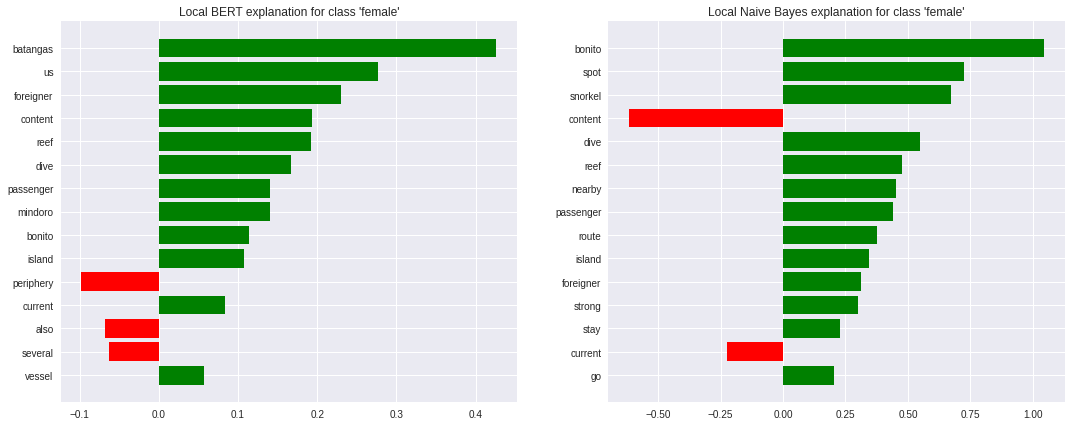

Index: 126
Yesterday, I cleaned up Joyce Road , so today I cleaned my street ( Campbell) because it was full of trash and it was very awful and gross. I thought it is time for me to get up and clean up this street before it gets worse. 

True label = 1 (0: male, 1: female)


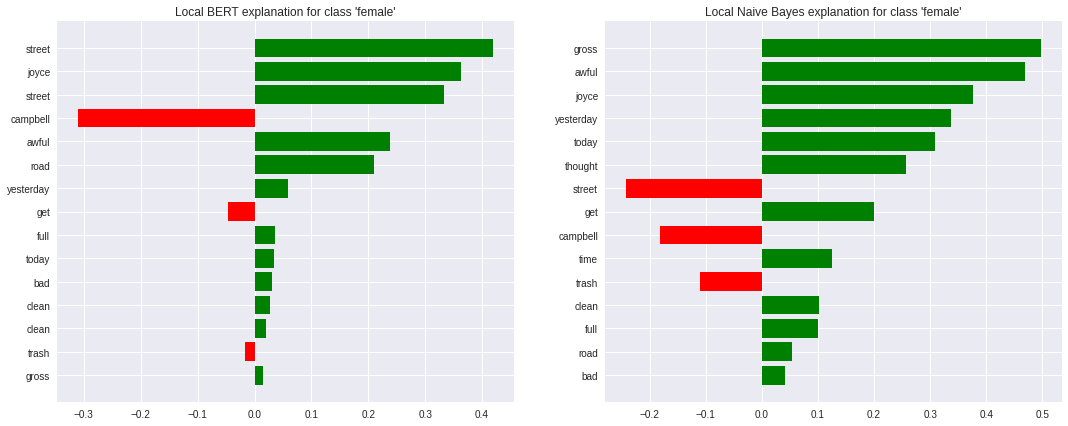

Index: 127
I'd dare say your not as good with women as you wish you were, you're looking for something that can take you above and beyond 99% of men for free, it's here, you just have to reach out and grab it  

True label = 1 (0: male, 1: female)


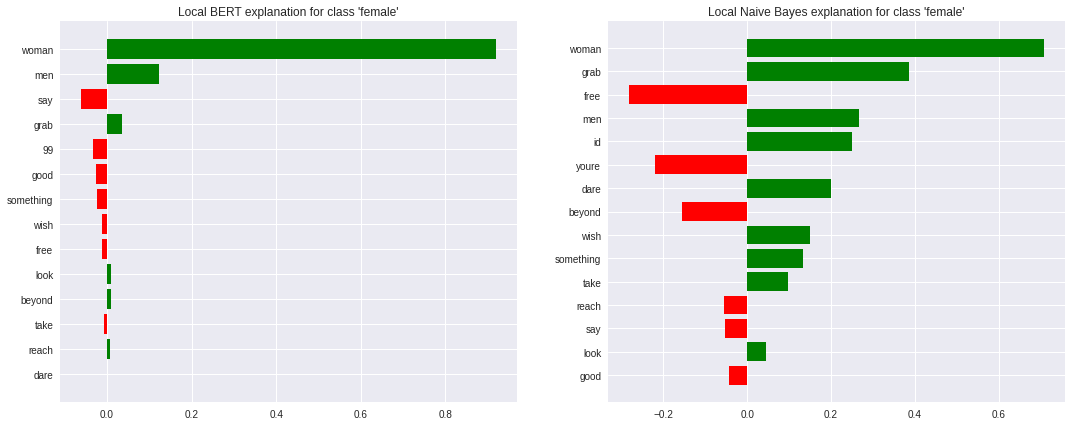

Index: 140
 Thanks again to everyone who's given us feedback on this project. And above all special thanks to both Leroy and Laurie - Leroy for encouraging us to continue the community and Laurie for helping us make it happen. This community wouldn't be here if it weren't for them.  

True label = 0 (0: male, 1: female)


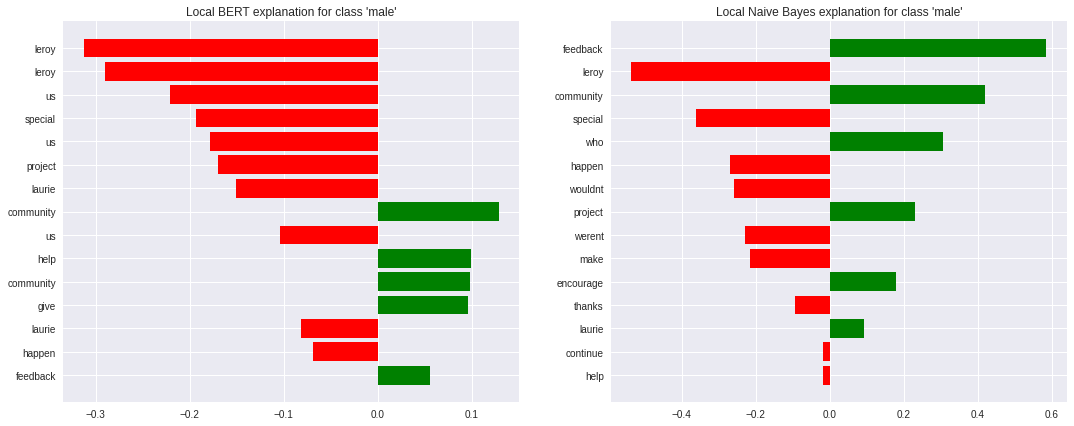

Index: 145
I'm not saying that America is this terrible disgusting country. Well I'm not completely saying that. What I am commenting on is the the patriotism of American's that seem to always offend other countries when speaking of how great America is. You don't see African's saying look at those Indonesians starving bastards! No because it's almost like the pot calling the kettle black.
 

True label = 0 (0: male, 1: female)


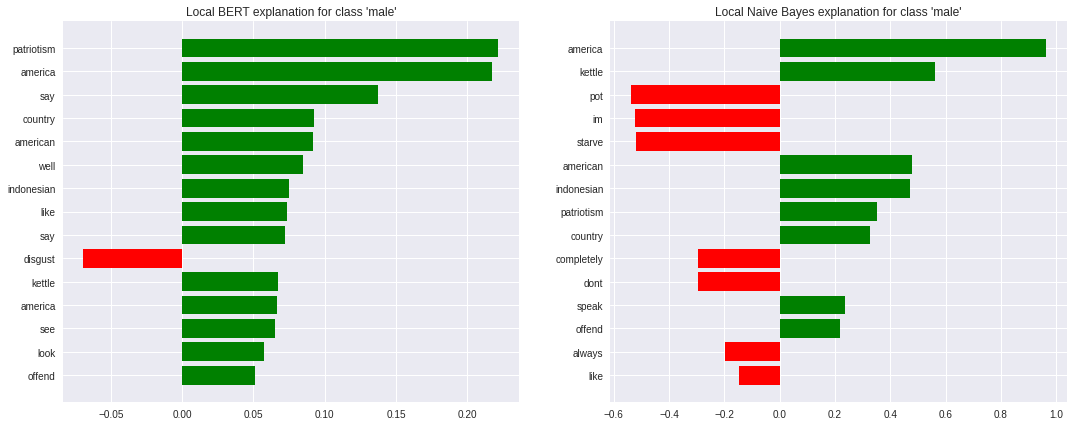

Index: 148
oh, The breakfast flakes sprinkle on some paradox ...hear one happy bird a perceived delight!
at the dark edge of twilight …
singing his moon song  

True label = 0 (0: male, 1: female)


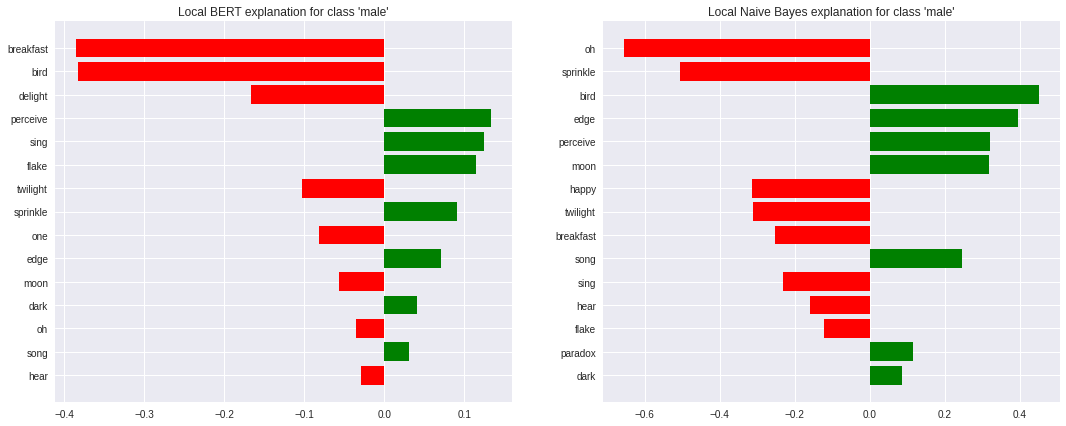

Index: 149
XM Satellite Radio, with its over 130 stations (most commercial-free) can appeal to anyone, but it has real appeal to those of use who do some long distance driving.  you know, those drives that leave you hitting the scan button on your AM/FM radio looking for a signal, any signal that will pierce the night.   

True label = 0 (0: male, 1: female)


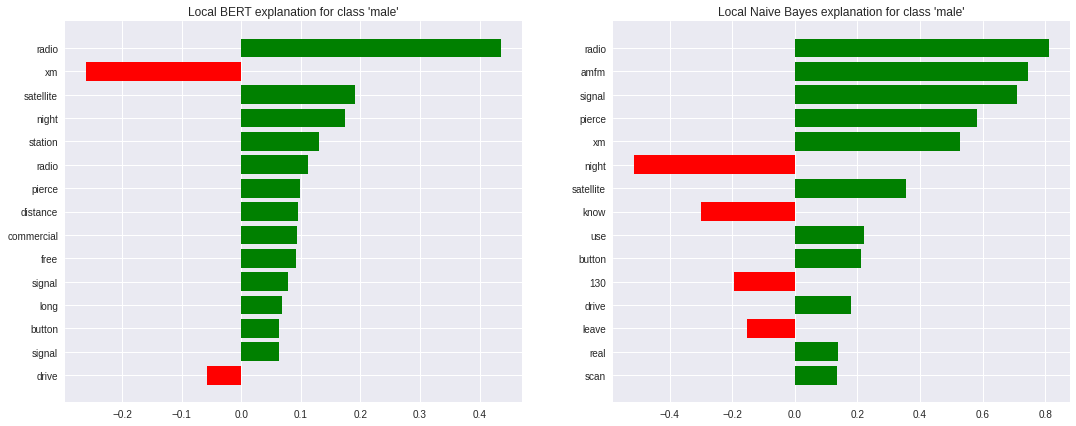

Index: 151
Nithin a lovable friend of mine. i used to share him many matters. he too shares with me his views. He is jovial type. he does anything for a friend. he is really a care taker of mine.he is a friend of mine from LKG itself.hope we will be friends life long. we cant forget our school days in life.best of luck da mapila 

True label = 0 (0: male, 1: female)


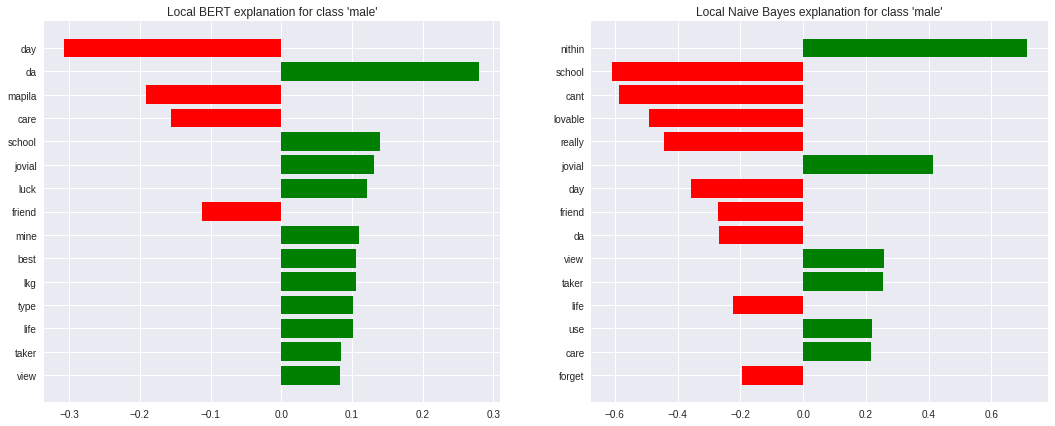

Index: 159
In 1970 I got out of the Navy..... and at that time met my soon to be wife Deborah she was a school teacher. One year later we were married. For the next 2 years Debbie was teaching high school so that I could go to culinary arts school to become a chef.

 

True label = 0 (0: male, 1: female)


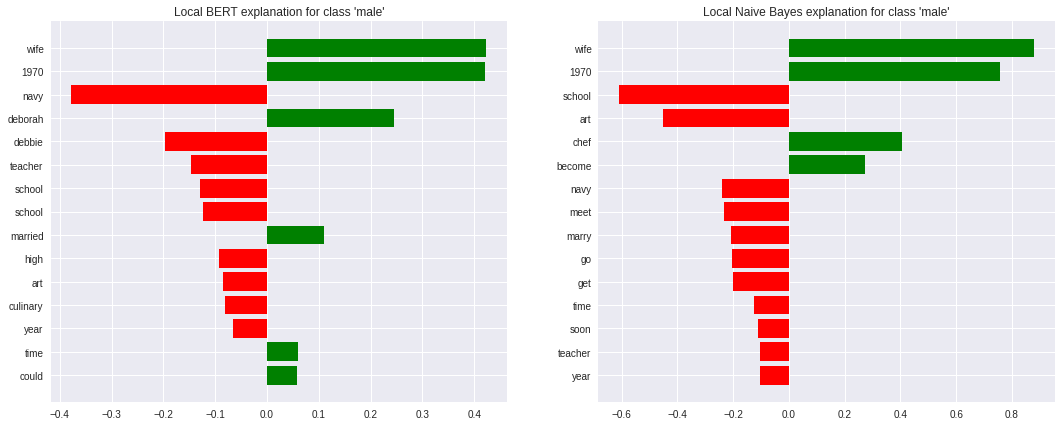

Index: 167
Roger Conway 
I have taught language, writing, literature and media studies from the ninth grade through graduate school. The greatest amount of my publishing has been online. I'm currently listed as Associate Prof. Emeritus at Southern Connecticut State University.
 

True label = 0 (0: male, 1: female)


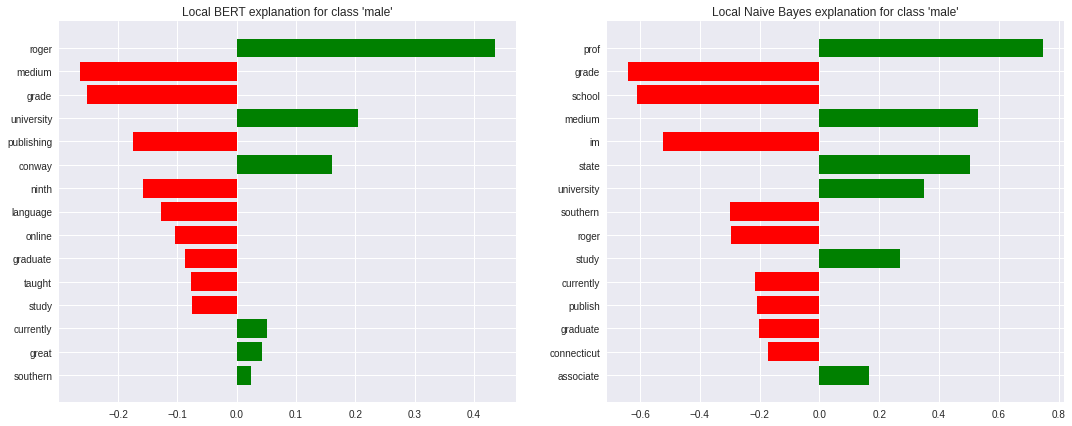

Index: 180
I've started a monthly Crafty Night & yesterday evening was the kickoff. (I need to come up with a catchy name. "Crafty Night" is kinda b-l-a-h.) 6 ladies joined me to make some of those popular flat-backed marble magnets. SUPER easy to make! And super DUPER fun! It felt awesomely terrific to get all crafty. 

True label = 1 (0: male, 1: female)


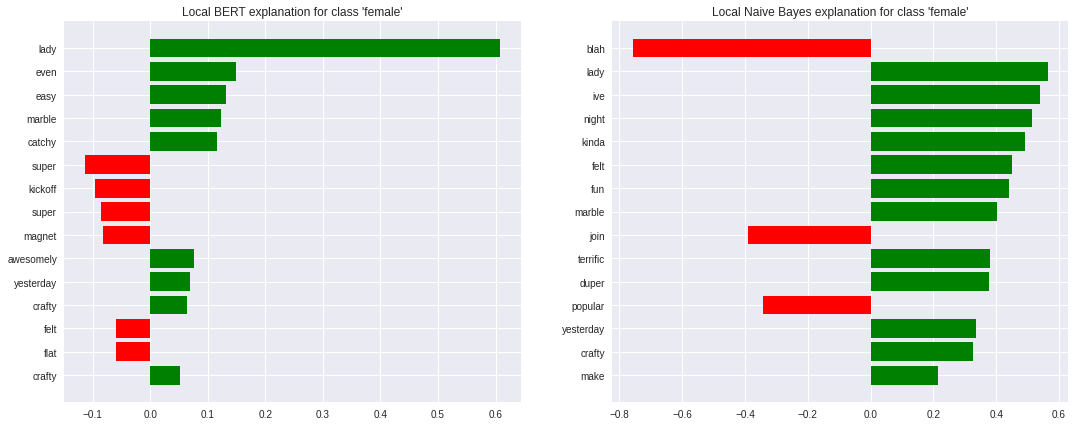

Index: 200
ur my honey bunch ,sugar plum, cuppy yuppy pumpkin, ur my sweetie pie
ur my cuppy cake gumdrops , smikibikimi,the apple of my eye
and i love you so , and i want you to know,
that ill always be right here ,
and i love to sing this song to you,
because you are my baby bear:D  

True label = 1 (0: male, 1: female)


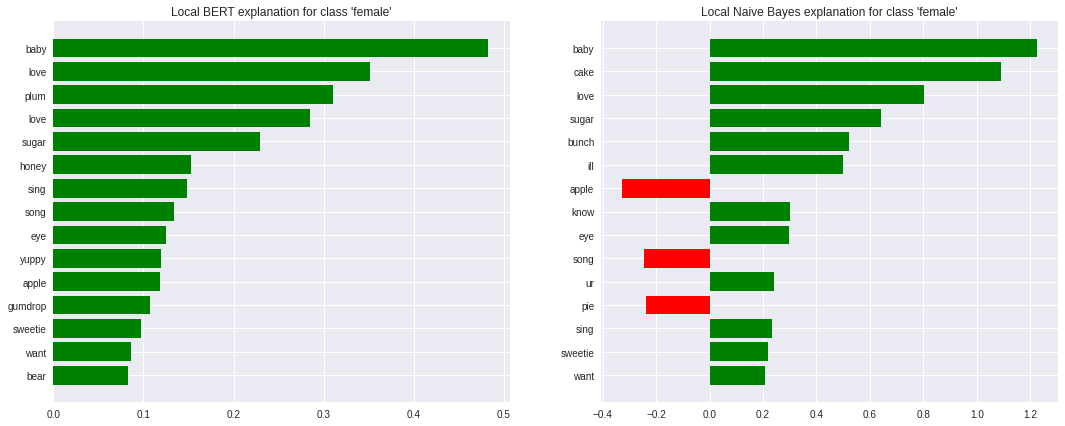

Index: 243
I cannot get enough of this show and its books. The plots and the chemistry between the characters is fantastic and believable. They all seem down to earth. The show has equal part humor and seriousness which I love. Also, when they have emotional story lines the actors portray it so well. Also John Barrowman is just amazing.   

True label = 1 (0: male, 1: female)


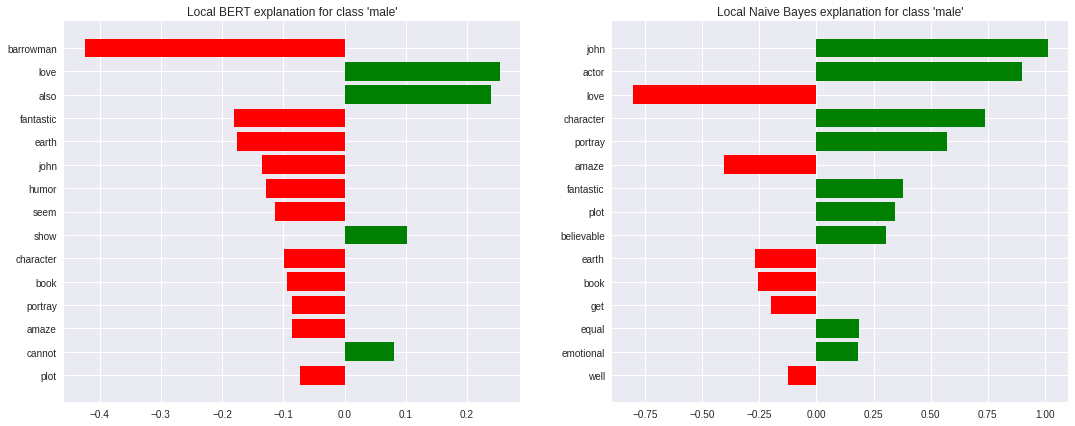

Index: 246
Coming from a warm country, the slight chilly San Francisco air was already freezing me. Good thing I have a comfortable room with a soft bed and plenty of pillows that warmed me during the night. 

True label = 1 (0: male, 1: female)


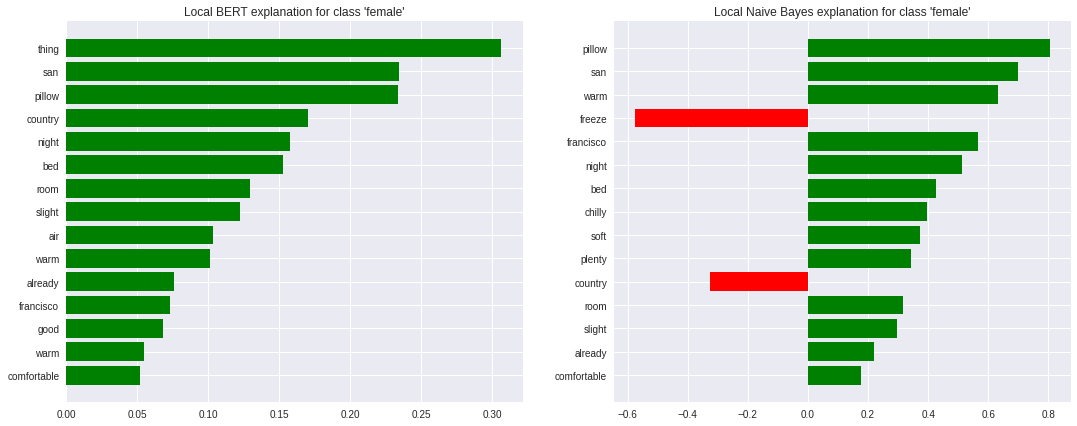

Index: 265
Our coral watching continued as we proceeded to the Coral Garden. It was a sloping reef that also had several coral varieties. It was truly like a garden beneath the sea. Spiky corals, fluffy ones, round ones—you name it and you’ll find them dancing with the waves underwater.  

True label = 1 (0: male, 1: female)


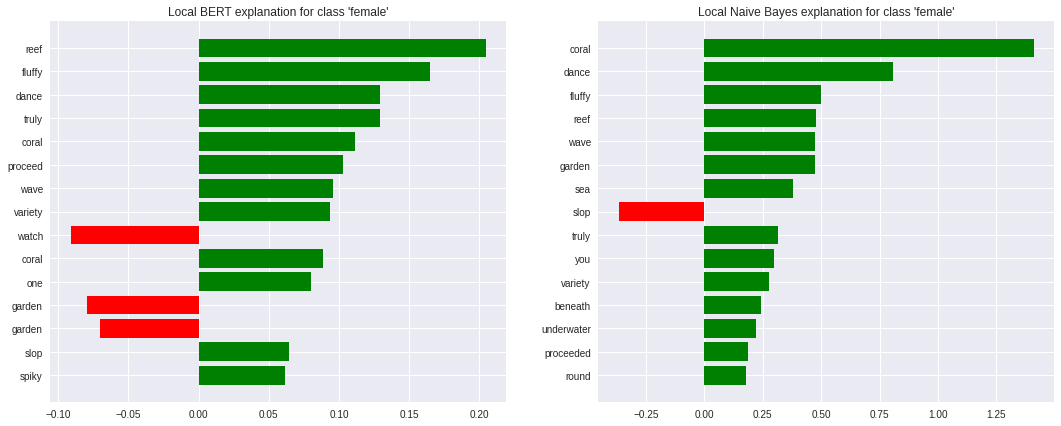

Index: 301
I got into watching the Doctor Who showd a few years back and found myself glued to the screen because  the show is super & has peaked my desire for more.  

True label = 1 (0: male, 1: female)


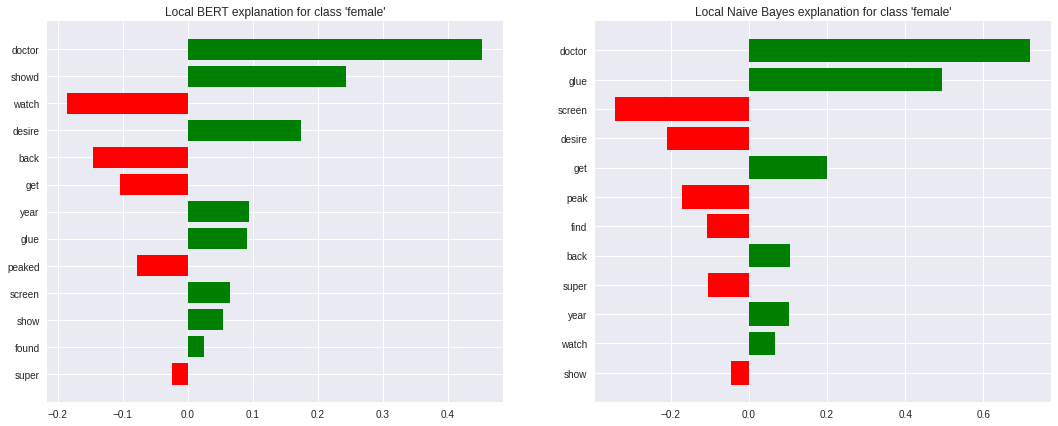

Index: 304
 We chuckled with him when he talked about losing his hair and we told him there was no shame in admitting he was just plain scared. He came for advice and he got that, too. His journey was a short one, but he made an impression. He left his mark, and that's what it's all about.   

True label = 1 (0: male, 1: female)


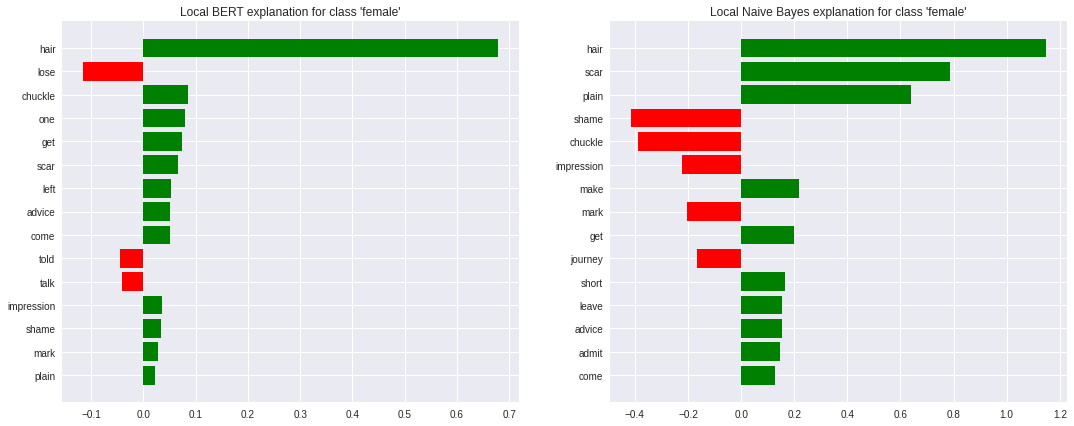

Index: 340
So shall I be river letting you flow through brook; like the lines of this poem, I let you paint the sky as blue or the streets of a certain town lazy while there in a brothel, a girl brothel, a girl without the keys of her self allows you the street you make a tone darker. 

True label = 0 (0: male, 1: female)


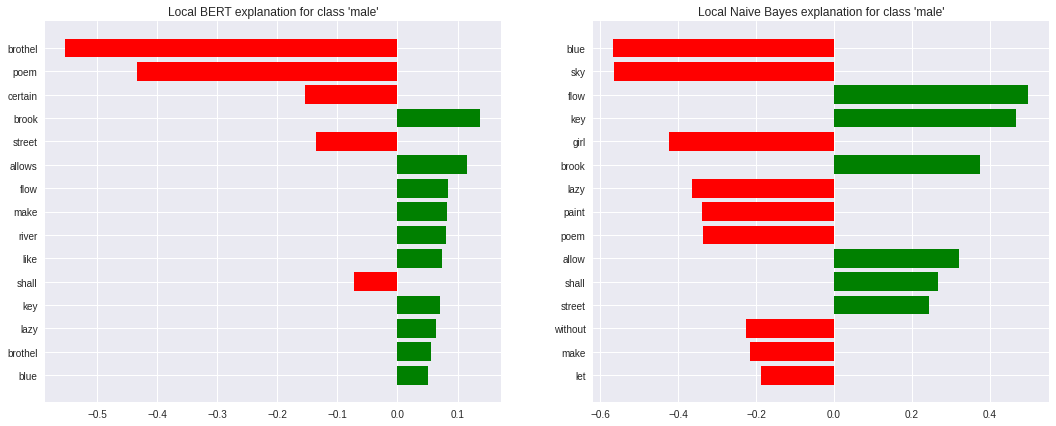

Index: 353
A small island was discernible from the distance, our destination for that day. For locals and divers, that was Apo Island, known for its rich underwater life.  

True label = 1 (0: male, 1: female)


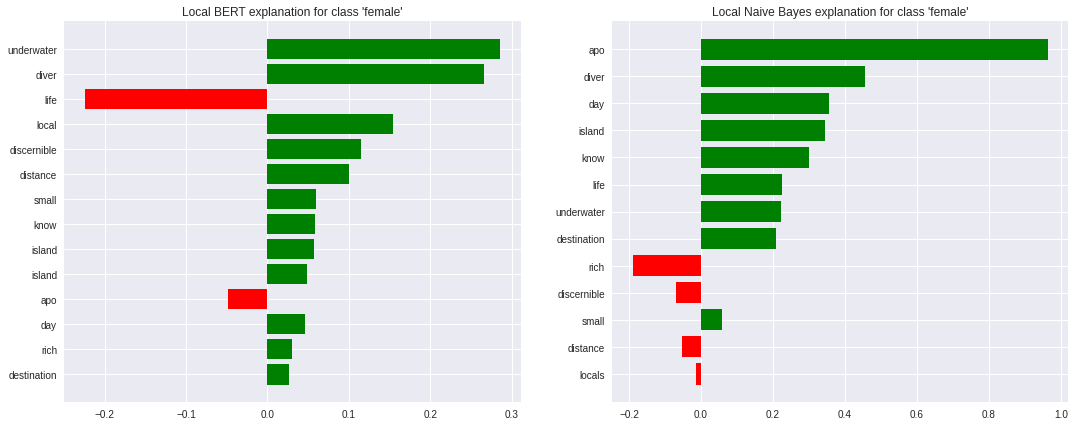

Index: 380
I had planned a whole big post for yesterday, but as you may have noticed, I missed my blogligation yesterday. Yup, that's right, I fucked up again. Oh well, I'm over worrying about it these days. If I remember, I remember, if I don't I don't.

 

True label = 0 (0: male, 1: female)


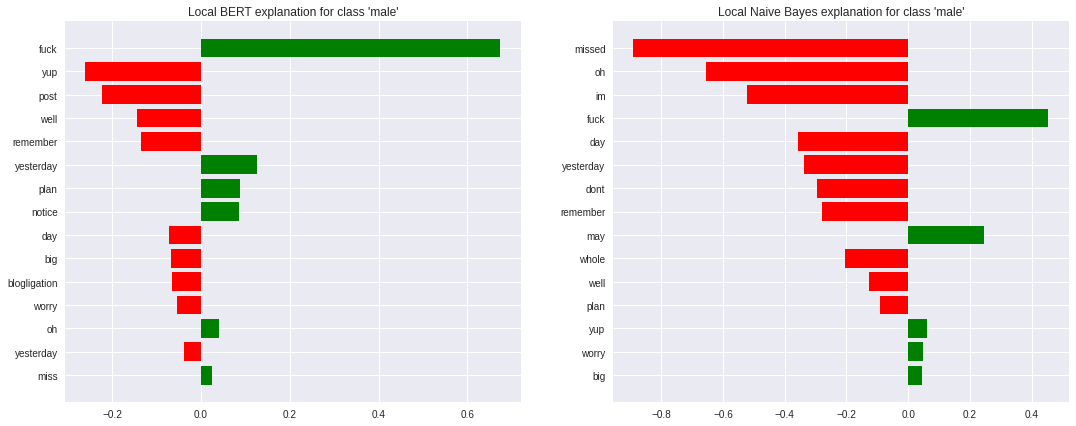

Index: 382
Lots of things in life don't die but instead evolve or get reinvented. Such is the case with this blog. This has been a great blog to write and we have had many dedicated followers over the past one and one half years. But now it's time to move on from this blog to... another blog.  

True label = 1 (0: male, 1: female)


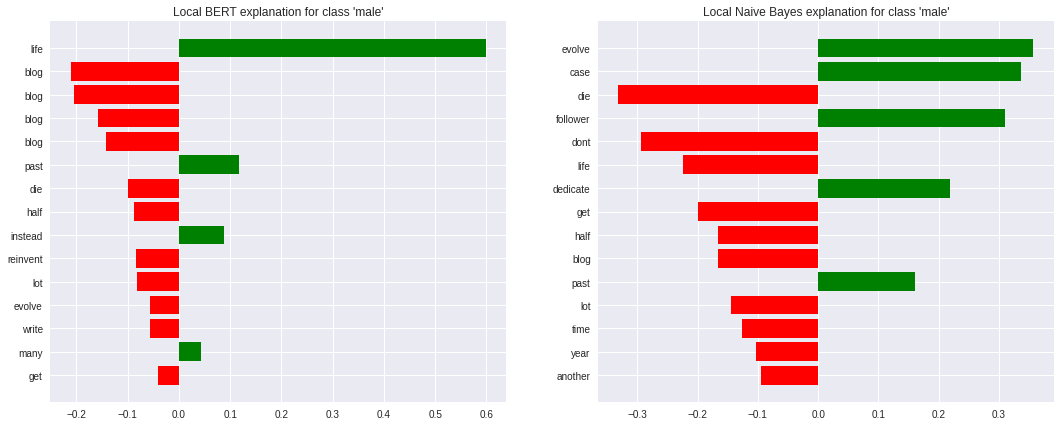

Index: 397
i am an introspective, quiet, thoughtful, often lost, sometimes found, conglomeration of people, events, and expectations filled and unfulfilled who meanders around a relatively small portion of this earth bringing what goodness i can to the time i am given. some recognize, accept, and cherish the somewhat insular sometimes bewildered by it all person that i actually am. 

True label = 0 (0: male, 1: female)


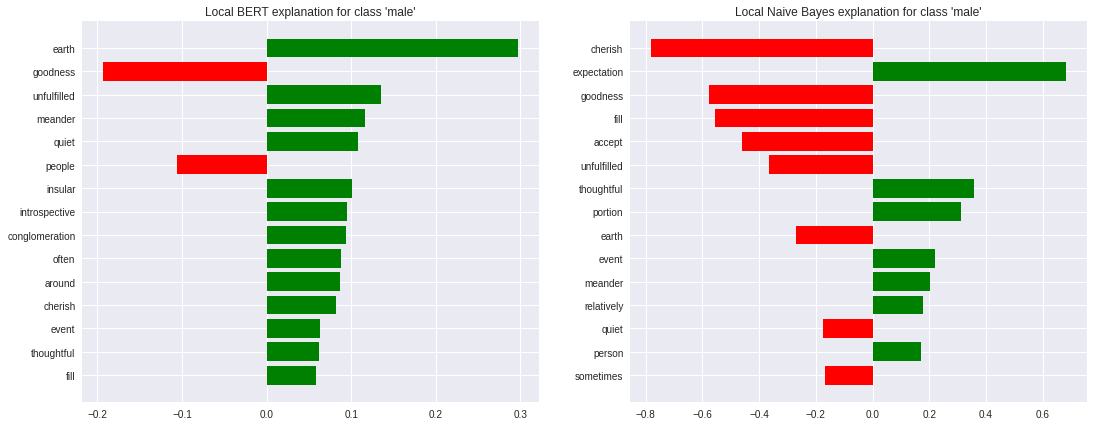

Index: 401
Still the captain smiled, but he wasn't blinking and his grin was fixed. I'm not sure who's teeth were worse, but this would be a battle between man and land. The waves were still pushing us Beachfront actionaround and rain was punching down from the sky 

True label = 0 (0: male, 1: female)


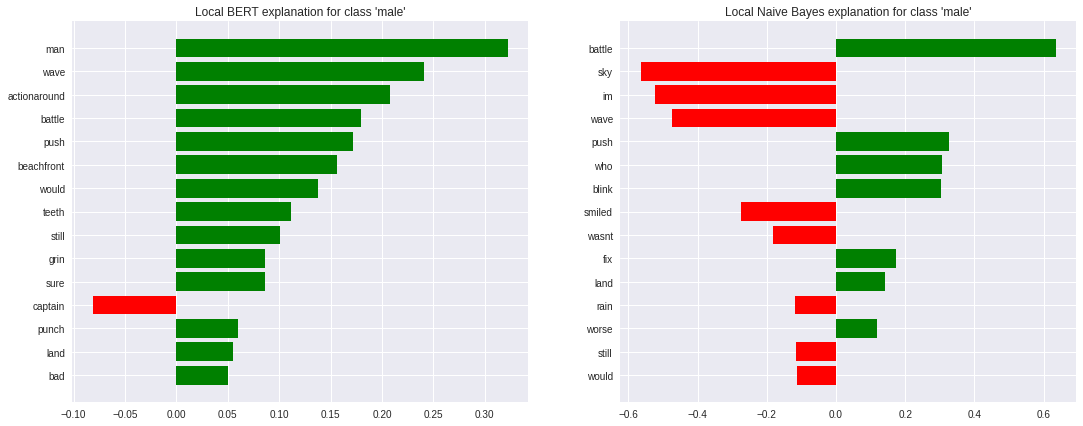

Index: 406
Well I have been working on a lot of thing. Finishing up the semester and trying to get my master degree program started as well as my freelance, but i am always working in 3D on something else. Here is something that I made last night in ZBrush. The Hair I am sure about, but i will more then likely change. 

True label = 0 (0: male, 1: female)


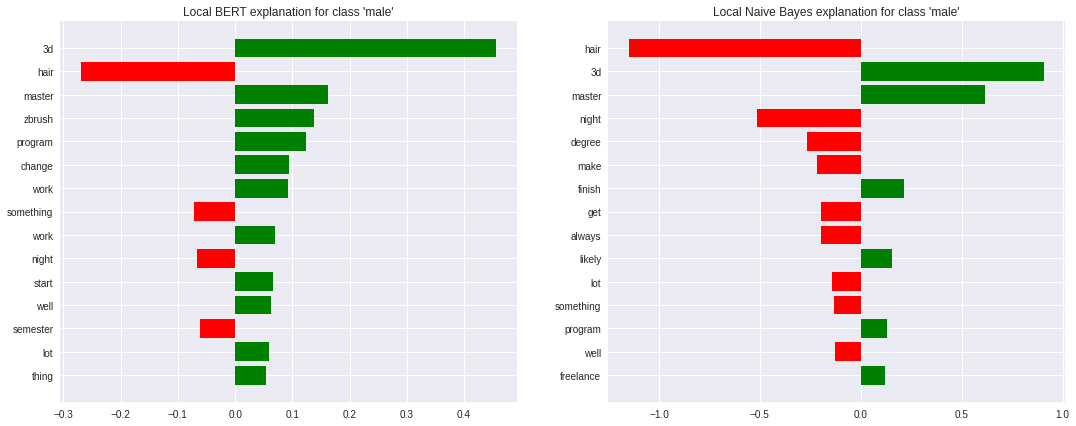

Index: 408

Gutter is a new magazine of 'New Scottish Writing.' I am delighted that I have a poem in their first issue. There are lots and lots of good things in the beautifully designed magazine, so go and subscribe please, here. It is very reasonably priced.  

True label = 0 (0: male, 1: female)


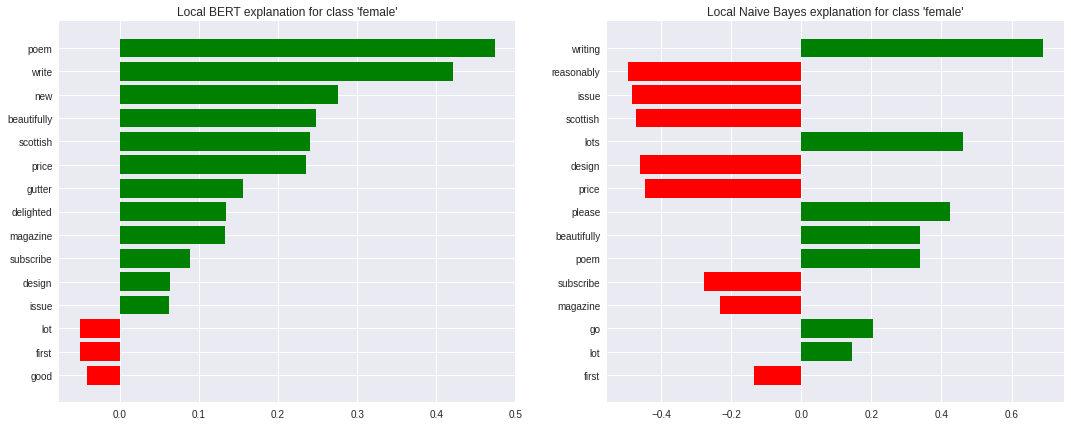

Index: 428
Lately, I've been working on a collection of portraits that aim to capture the various personalities that have populated Major League Baseball throughout its history. I'm a diehard Mets fan (no apologies necessary) so the characters of the '86 Mets were an obvious jump-off point for me.

 

True label = 0 (0: male, 1: female)


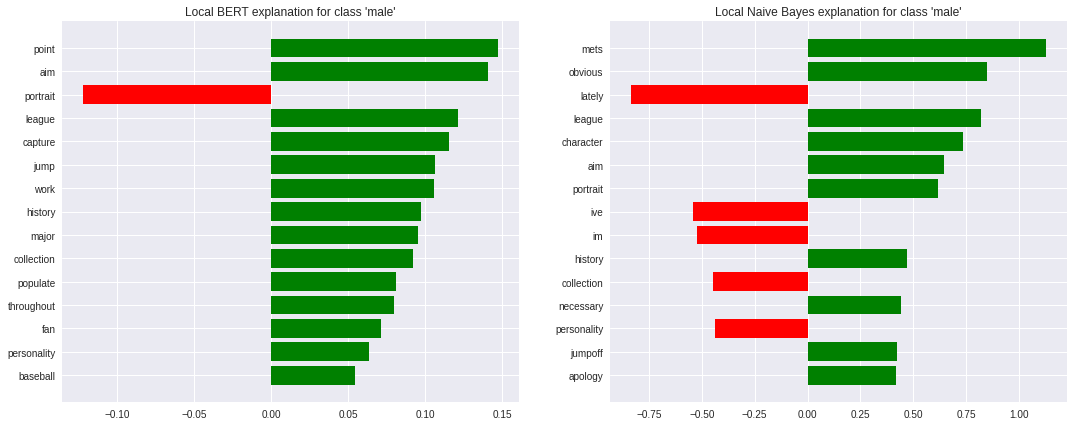

Index: 491
This camcorder is really good for the price and it has an easy button for people who are not good with camcoders. There is also a touch screen in the camcorder ang you can turn the screen so you can see yourself. It also has a built in lens cover and you don't have to worry about lossing it.   

True label = 0 (0: male, 1: female)


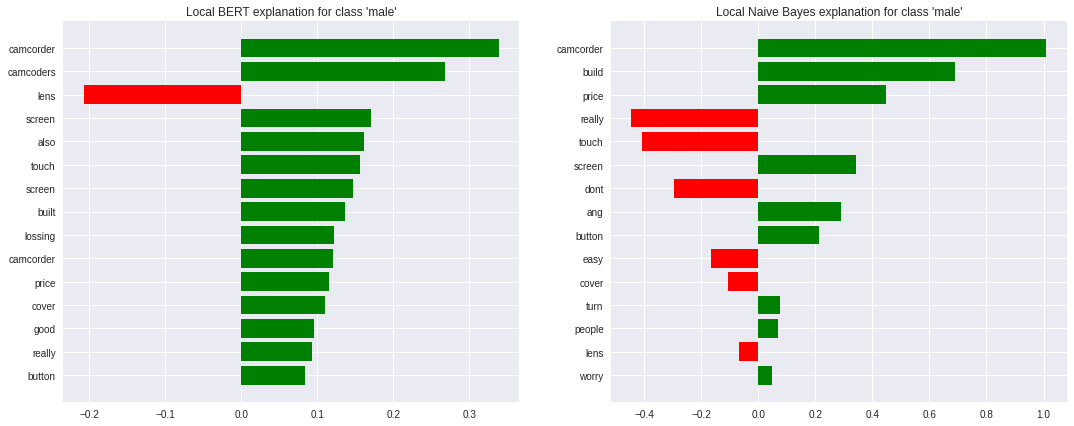

Index: 502
Hai, Sasha here.To me, women was very easier to lose their weigth because everywhere we can saw no men in this world do housework accept forced. women was did the housework and its can be women was very easier to lose thier weigth....Anything you want to commentttt???????  

True label = 1 (0: male, 1: female)


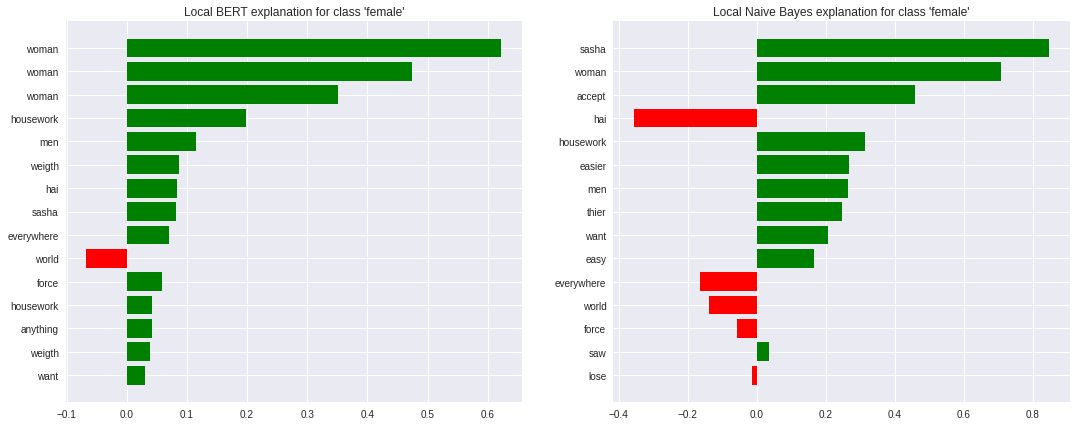

Index: 520
This company is great.  Its a new company but its stock will truly show just how much.  They have reached some high profit numbers.  Soon to be again, and steady!
I look for Metro to become more diverse and expect them to take on a nice share of the cellular market from the "big guys" and make it more affordable to all.   

True label = 1 (0: male, 1: female)


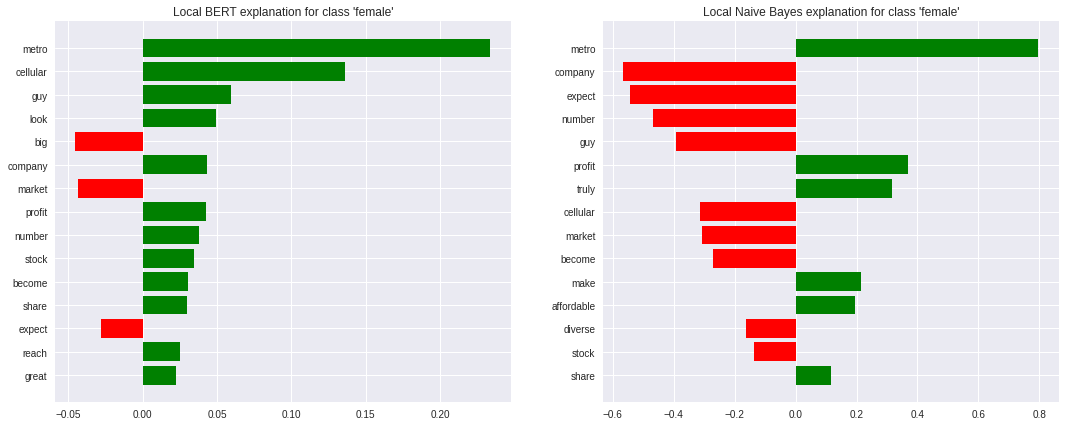

Index: 549
i love these vitamins when they were from AARP and I would buy them from walgreen's   

True label = 0 (0: male, 1: female)


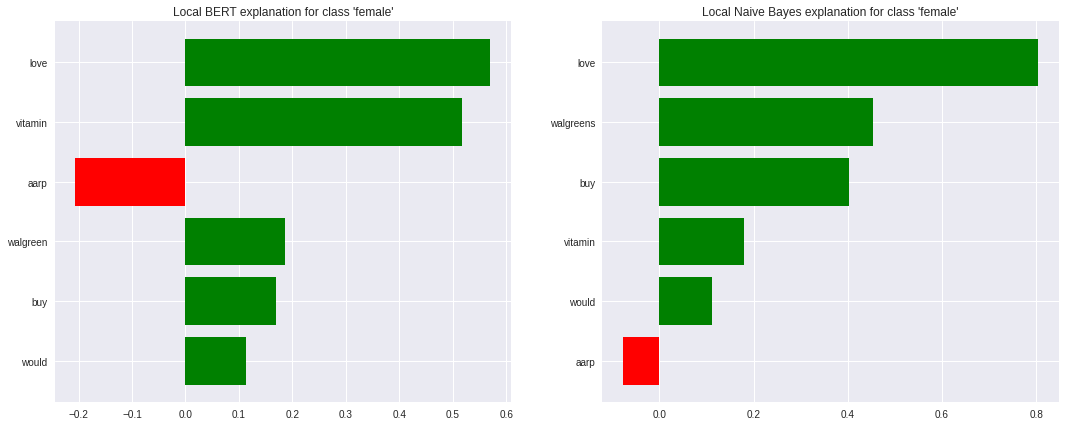

Index: 557
After days of rain that dropped 5-8 inches in the Boston area, the sun is out, the waters are slowly receding and it's beginning to feel like spring! These beautiful crocus blossoms greeted me at my side door this morning as I was leaving for the office - I'm pleased to share them with you. 

True label = 0 (0: male, 1: female)


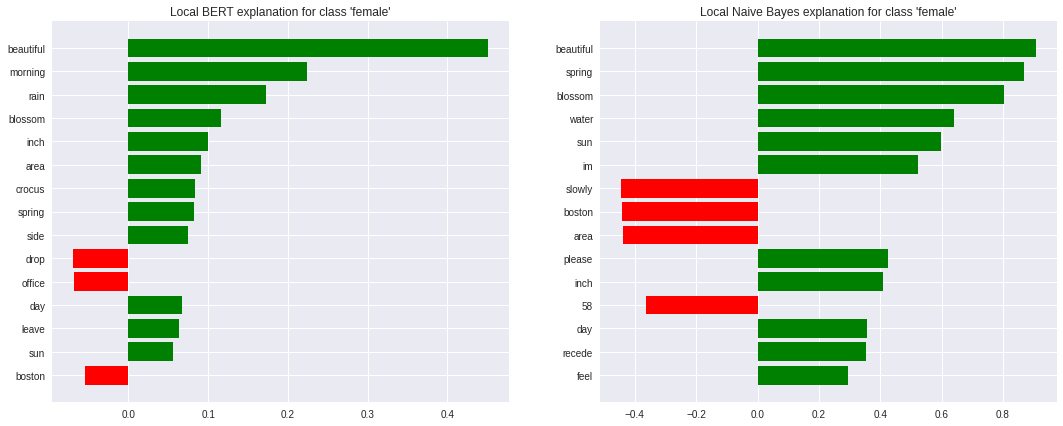

Index: 563
I think any universal health care plan would have to come with a income based scheme or means testing. If you can afford to pay for health care you should pay, however you would be able to recieve a percentage back through a medicare rebate scheme.  

True label = 0 (0: male, 1: female)


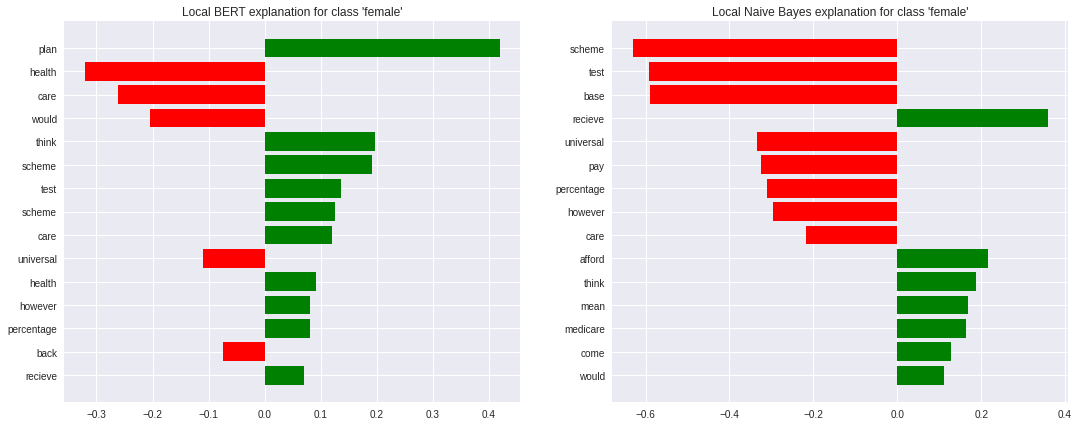

Index: 572
I just finished reading Rainbows End by Vernor Vinge and I recommend it. It is science fiction in the style of Gibson's Neuromancer series or Stephenson's Diamond Age but less cyberpunk. In Rainbows End, Vinge describes a near-future which includes augmented reality and life-changing medical advances.
 

True label = 0 (0: male, 1: female)


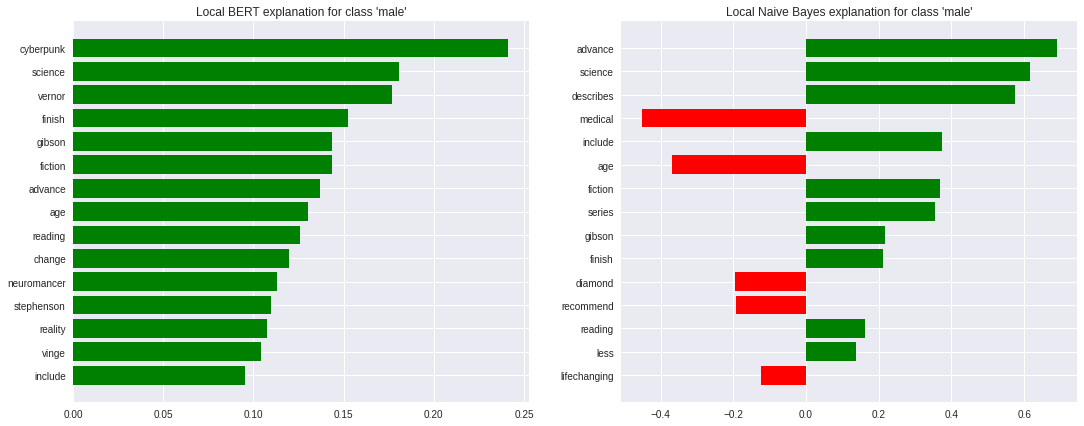

Index: 586
This was high season and spoilt and busy? We were soaked and there was no place to stay, yet after the noisy crowds of the other islands, this was a chance to exhale.  

True label = 0 (0: male, 1: female)


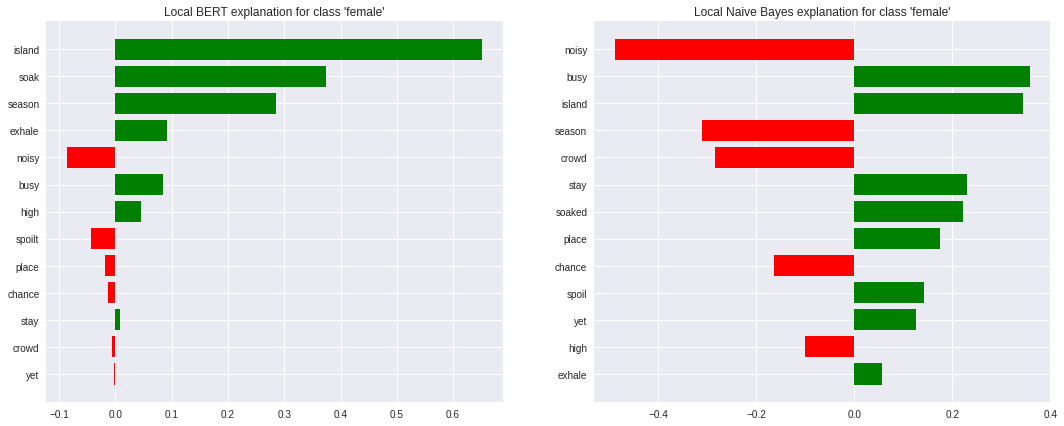

Index: 593
Finally we broke through to the calmer side of the island, The rain was lighter here, waves calmer, we could see the coast of Thailand in the distance and everyone seemed to breath easier now we were sheltered on this side of the island.  

True label = 0 (0: male, 1: female)


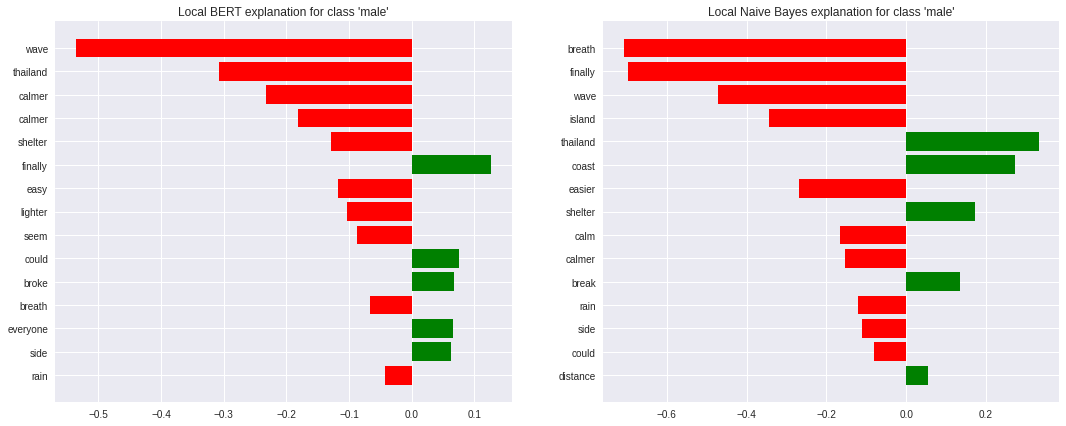

Index: 594
I have been used for almost 4 years. The car is just "nice". I remember it never made me " "terrible". I would say that it is economical. More, the size is meet to family riding. I mean the utility is kind of "a Choice". Frankly speaking, I never dissapoint to put my money for this " marvelous car   

True label = 1 (0: male, 1: female)


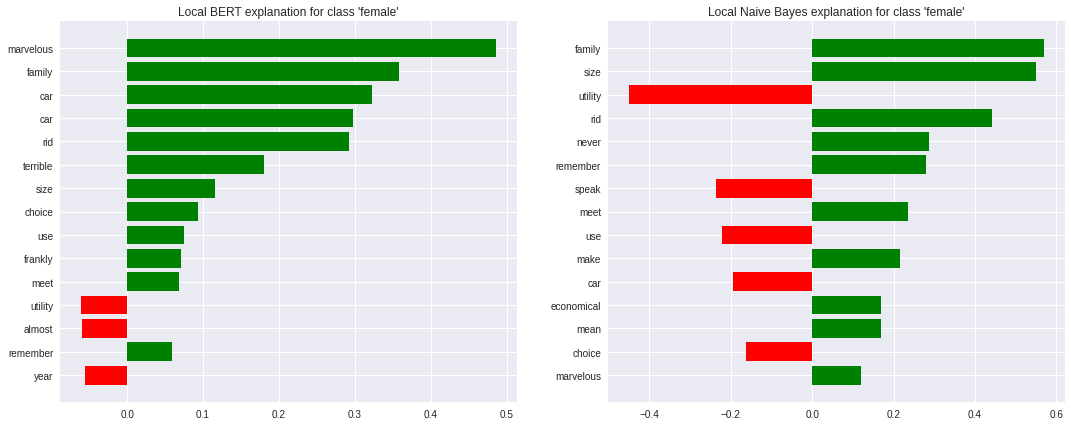

Index: 598
I have delivered both of my children at Evanston Northwestern Memorial Hospital. One of them I had naturally with forceps, the other via emergency c-section. While personally the experience was mixed, I was generally happy with the hospital and the overall facilities.  

True label = 1 (0: male, 1: female)


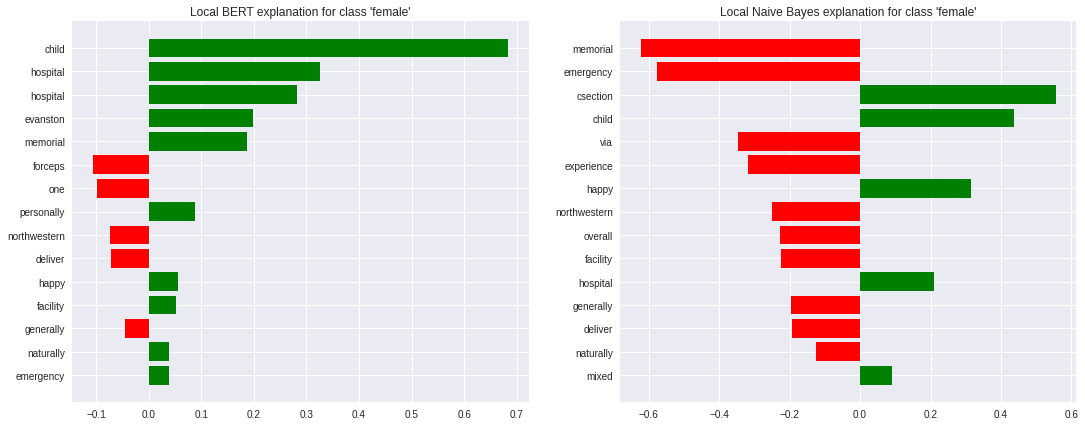

In [55]:
for i in full_overlap_df[full_overlap_df.post_lengths < 65].index:
    print("Index:", i)
    plot_explanations(i)

### Examples where BERT has opposing classes for "same" word feature

In [61]:
n_feat = 15 #could increase this if needed
hits = []
for j in range(len(full_explanation_df)):
    sample = full_overlap_df.iloc[j]

    top_bayes = sorted(sample.ig, key=lambda x: abs(x[1]), reverse=True)[:n_feat]
    bayes_feat = [t[0] for t in top_bayes]
    bayes_attrib = [t[1] for t in top_bayes]
    
    seen = []
    seen_attrib = []
    dupl = []
    for i in range(len(bayes_feat)):
        if bayes_feat[i] not in seen:
            seen.append(bayes_feat[i])
            seen_attrib.append(bayes_attrib[i])
        else:
            dupl.append(i)

    for idx in dupl:
        seen_idx = seen.index(bayes_feat[idx])
        if np.sign(seen_attrib[seen_idx]) != np.sign(bayes_attrib[idx]):
            hits.append((j,bayes_feat[idx]))
        
print(hits)
indices = [h[0] for h in hits]
len(set(indices))

[(10, 'ppl'), (10, 'ppl'), (21, 'miley'), (21, 'miley'), (24, 'vivek'), (44, 'female'), (46, 'cut'), (62, 'epilator'), (64, 'sometimes'), (78, 'school'), (80, 'sandstorm'), (86, 'teacher'), (101, 'texas'), (106, 'master'), (117, 'girl'), (128, 'ella'), (134, 'grand'), (146, 'young'), (162, 'wine'), (162, 'chameleon'), (165, 'know'), (166, 'porridge'), (168, 'lama'), (168, 'dalai'), (172, 'moscow'), (176, 'new'), (184, 'swim'), (189, 'woman'), (189, 'woman'), (210, 'dr'), (217, 'ward'), (222, 'rahul'), (222, 'rahul'), (232, 'school'), (250, 'light'), (250, 'light'), (256, 'siddharth'), (258, 'twitter'), (272, 'woman'), (288, 'film'), (300, 'mardi'), (310, 'hi'), (318, 'world'), (334, 'love'), (335, 'aol'), (337, 'fiance'), (337, 'fiance'), (338, 'ultram'), (340, 'brothel'), (348, 'love'), (351, 'indian'), (358, 'god'), (380, 'yesterday'), (388, 'arthouse'), (393, 'job'), (409, 'gerry'), (440, 'love'), (446, 'fil'), (449, 'human'), (453, 'call'), (457, 'congress'), (458, 'last'), (460, '

81

In [72]:
for h in hits:
    if full_overlap_df.post_lengths[h[0]] < 100:
        print(h)

(146, 'young')
(165, 'know')
(172, 'moscow')
(258, 'twitter')
(340, 'brothel')
(351, 'indian')
(358, 'god')
(380, 'yesterday')
(440, 'love')
(465, 'work')
(471, 'college')
(487, 'apple')
(513, 'photo')
(553, 'love')
(553, 'dw')
(555, 'blahblah')
(563, 'care')
(563, 'health')
(582, 'burnout')
(590, 'life')


Many people start to question their own sanity for ever having loved such a beast in the first place. And whether you like it or not, you need to go back in your head to find that person you did love way back when. That can go a long way toward a little bit of reality. If the person you married was a good person then, they're probably still a good person, just not showing it at the moment.  

True label = 0 (0: male, 1: female)


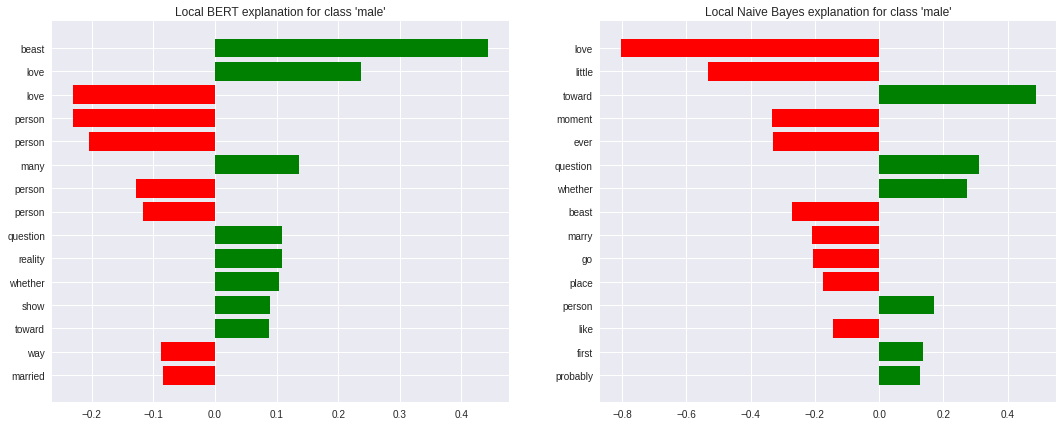

In [76]:
plot_explanations(440)

As I sit here late at night I mourn what I have lost. I have perhaps mourn what I have lost for too long. It seems as life moves forward I keep glancing in the rearview mirror to mourn rather than look forward to what is to come. This has crippled my life. I have stopped to gaze into where I have been rather than charge forward to where I am going.

 

True label = 0 (0: male, 1: female)


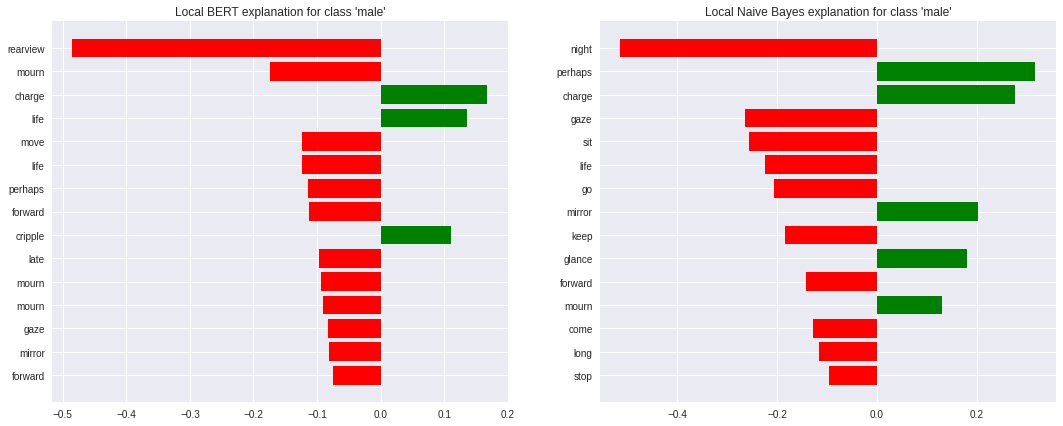

In [78]:
plot_explanations(590)